# 3.2_esgbert_model

The following notebook was carried out at a stage in the project where the possibility of a supervised learning approach was being explored. This notebook looks to engineer some features using ESGBert, a pretrained language model trained on a corpus of sustainability text. A great feature of ESGBert is the ability to get the proportion of 26 ESG Metrics (based on SASB ESG metrics) within a report. The idea was to carry out a clustering exercise on these 26 features, to establish if they could be a useful feature. 

Ultimately, this work was not continued, as the lack of data for historical esg scores made it unfeasible to try to predict ESG scores. However, the feature engineering is an interesting exploration into how ESGBert could be used for an alternative project.

### Package imports

In [273]:
# general imports
import pandas as pd
import numpy as np
import capstone_utility_functions as cuf
import seaborn as sns
import matplotlib.pyplot as plt

# webscraping imports
from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests

# misc imports
import joblib
import re
import io 
from PyPDF2 import PdfReader
import pdftotext

# NLP imports
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk.corpus
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

# LDA imports
import gensim 
import pyLDAvis
from gensim import corpora
import pyLDAvis.gensim_models
from sklearn.decomposition import LatentDirichletAllocation
pyLDAvis.enable_notebook()

### Data imports

The following data comes from a previous dataframe, where each row contains a report for a different company. Feeding an entire report into ESGBert may not be an optimal approach, and it could be better to split by paragraphs like for LDA, but the aim is to get a quick understanding of if this approach could be useful. If it turns out to be of use, then refinement can come later.

In [274]:
df_combo = joblib.load('../data/clean_report_bank.pkl')

In [275]:
df_combo = df_combo.drop(columns=['raw_txt_camel_removed','raw_txt_nums_split','raw_txt_nums_removed'])

In [276]:
df_combo

ticker                                name  \
0       MMM                      3M Corporation   
1       ABB                             ABB Ltd   
2       ABT                 Abbott Laboratories   
3      ABBV                          Abbvie Inc   
4       ABM                ABM Industries, Inc.   
...     ...                                 ...   
1010   VRTU                        Virtusa Corp   
1011    WBA      Walgreens Boots Alliance, Inc.   
1012    WMG                  Warner Music Group   
1013   WNFM                   Wayne Farms, Inc.   
1014    WDC  Western Digital Technologies, Inc.   

                                                    url  \
0     https://www.responsibilityreports.com/HostedDa...   
1     https://www.responsibilityreports.com/HostedDa...   
2     https://www.responsibilityreports.com/HostedDa...   
3     https://www.responsibilityreports.com/HostedDa...   
4     https://www.responsibilityreports.com/HostedDa...   
...                                                 ...   
1010  https://www.responsibilityreports.com/HostedDa...   
1011  https://www.responsibilityreports.com/HostedDa...   
1012  https://www.responsibilityreports.com/HostedDa...   
1013  https://www.responsibilityreports.com/HostedDa...   
1014  https://www.responsibilityreports.com/HostedDa...   

                                                raw_txt  \
0      \n \n \n●\n ●\n \n  \n \n \n●\n ●\nConten ts\...   
1     Environmental,  Social, &  Governance2021 2 | ...   
2     ANNUAL CORPORATERESPONSIBILITY REPORT2021 ON T...   
3     2021\nESG Action Report\nPeople. Passion. Poss...   
4     2021 ENVIRONMENTAL, SOCIAL & GOVERNANCE IMPACT...   
...                                                 ...   
1010  Whitbread  ESG Report 2022 Social Governance1\...   
1011  Wm Morrison Supermarkets PLC  Sustainability R...   
1012  PEOPLEPLANETCLIENTSCOMMUNITIES\nSUSTAINABILITY...   
1013  2021 GLOBAL ENVIRONMENTAL,  \nSOCIAL AND GOVER...   
1014  SustainabilityReport2021\nX5 for the future 2\...   

                                             clean_text  
0     conten ts message from our ceo impact kpi abou...  
1     environmental social governance environmental ...  
2     annual corporateresponsibility report on the c...  
3      esg action report people passion possibilitie...  
4      environmental social governance impact report...  
...                                                 ...  
1010  whitbread esg report social governance appendi...  
1011  wm morrison supermarkets plc sustainability re...  
1012  peopleplanetclientscommunities sustainability ...  
1013   global environmental social and governance es...  
1014  sustainabilityreport x for the future content ...  

[1015 rows x 5 columns]

In [277]:
#list of 26 ESG metrics which ESGBert can classify a text into. 
topic_list = ['Business_Ethics',
 'Data_Security',
 'Access_And_Affordability',
 'Business_Model_Resilience',
 'Competitive_Behavior',
 'Critical_Incident_Risk_Management',
 'Customer_Welfare',
 'Director_Removal',
 'Employee_Engagement_Inclusion_And_Diversity',
 'Employee_Health_And_Safety',
 'Human_Rights_And_Community_Relations',
 'Labor_Practices',
 'Management_Of_Legal_And_Regulatory_Framework',
 'Physical_Impacts_Of_Climate_Change',
 'Product_Quality_And_Safety',
 'Product_Design_And_Lifecycle_Management',
 'Selling_Practices_And_Product_Labeling',
 'Supply_Chain_Management',
 'Systemic_Risk_Management',
 'Waste_And_Hazardous_Materials_Management',
 'Water_And_Wastewater_Management',
 'Air_Quality',
 'Customer_Privacy',
 'Ecological_Impacts',
 'Energy_Management',
 'GHG_Emissions']

In [278]:
# add empty columns for the 26 esg metrics
df_combo = pd.concat([df_combo,df_combo.reindex(columns=topic_list)], axis=1)

### ESGBert

The following code blocks focus on using a pretrained BERT model. This is a language model that has been trained specifically on ESG related corpus. The main feature which this project is to make use of is the ability to identify the proportion of a certain ESG metric within a corpus of text. If the input is a corpus of text (an ESG report), the output is 26 values, summating to 1, which indicate the proportion of the report given to each of the main ESG metrics. The goal is to see if these values can be used as features for a potential supervised learning project.

In [279]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("nbroad/ESG-BERT")

model = AutoModelForSequenceClassification.from_pretrained("nbroad/ESG-BERT")

It is recommended that the pickle below is loaded instead of running the model - takes a long time!

In [280]:
# import torch

# for index, row in df_combo.iterrows():
#     # Tokenize the input text
#     tokens = tokenizer.encode_plus(row[4], padding=True, truncation=True, return_tensors="pt")
#     # Classify the input text using the pre-trained ESG-BERT model
#     outputs = model(**tokens)
#     # # Get the predicted class label
#     # predicted_class = torch.argmax(outputs.logits).item()
#     # # add most common topic for report to dataframe
#     # row[31] = predicted_class

#     # Get topic probabilities for each document
#     encoded_docs = tokenizer.batch_encode_plus([row[4]], padding=True, truncation=True, return_tensors='pt')
#     outputs = model(encoded_docs['input_ids'], attention_mask=encoded_docs['attention_mask'])
#     probs = outputs[0].softmax(dim=1)
#     probability_list = list(probs[0].detach().numpy())
#     for p,header in zip(probability_list, topic_list):
#         df_combo.loc[index,header] = p


In [281]:
# df_bert_topics = joblib.dump(df_combo, '../data/df_bert_topics.pkl')

# Clustering Exercise

In [282]:
import joblib
df_bert_topics = joblib.load('../data/df_bert_topics.pkl')

In [283]:
df_bert_topics.drop(columns='most_common_topic')

ticker                                name  \
0       MMM                      3M Corporation   
1       ABB                             ABB Ltd   
2       ABT                 Abbott Laboratories   
3      ABBV                          Abbvie Inc   
4       ABM                ABM Industries, Inc.   
...     ...                                 ...   
1010   VRTU                        Virtusa Corp   
1011    WBA      Walgreens Boots Alliance, Inc.   
1012    WMG                  Warner Music Group   
1013   WNFM                   Wayne Farms, Inc.   
1014    WDC  Western Digital Technologies, Inc.   

                                                    url  \
0     https://www.responsibilityreports.com/HostedDa...   
1     https://www.responsibilityreports.com/HostedDa...   
2     https://www.responsibilityreports.com/HostedDa...   
3     https://www.responsibilityreports.com/HostedDa...   
4     https://www.responsibilityreports.com/HostedDa...   
...                                                 ...   
1010  https://www.responsibilityreports.com/HostedDa...   
1011  https://www.responsibilityreports.com/HostedDa...   
1012  https://www.responsibilityreports.com/HostedDa...   
1013  https://www.responsibilityreports.com/HostedDa...   
1014  https://www.responsibilityreports.com/HostedDa...   

                                                raw_txt  \
0      \n \n \n●\n ●\n \n  \n \n \n●\n ●\nConten ts\...   
1     Environmental,  Social, &  Governance2021 2 | ...   
2     ANNUAL CORPORATERESPONSIBILITY REPORT2021 ON T...   
3     2021\nESG Action Report\nPeople. Passion. Poss...   
4     2021 ENVIRONMENTAL, SOCIAL & GOVERNANCE IMPACT...   
...                                                 ...   
1010  Whitbread  ESG Report 2022 Social Governance1\...   
1011  Wm Morrison Supermarkets PLC  Sustainability R...   
1012  PEOPLEPLANETCLIENTSCOMMUNITIES\nSUSTAINABILITY...   
1013  2021 GLOBAL ENVIRONMENTAL,  \nSOCIAL AND GOVER...   
1014  SustainabilityReport2021\nX5 for the future 2\...   

                                             clean_text  Business_Ethics  \
0     conten ts message from our ceo impact kpi abou...         0.782132   
1     environmental social governance environmental ...         0.001133   
2     annual corporateresponsibility report on the c...         0.002902   
3      esg action report people passion possibilitie...         0.007182   
4      environmental social governance impact report...         0.002739   
...                                                 ...              ...   
1010  whitbread esg report social governance appendi...         0.005172   
1011  wm morrison supermarkets plc sustainability re...         0.008013   
1012  peopleplanetclientscommunities sustainability ...         0.005486   
1013   global environmental social and governance es...         0.060803   
1014  sustainabilityreport x for the future content ...         0.003326   

      Data_Security  Access_And_Affordability  Business_Model_Resilience  \
0          0.009418                  0.002264                   0.012154   
1          0.002007                  0.001545                   0.025258   
2          0.003462                  0.005479                   0.025185   
3          0.002993                  0.646613                   0.016588   
4          0.000979                  0.008097                   0.017974   
...             ...                       ...                        ...   
1010       0.001694                  0.017889                   0.013870   
1011       0.001697                  0.056435                   0.021100   
1012       0.002140                  0.021878                   0.003489   
1013       0.012741                  0.040738                   0.072362   
1014       0.002220                  0.036121                   0.008167   

      Competitive_Behavior  ...  Selling_Practices_And_Product_Labeling  \
0                 0.006983  ...                                0.005663  

In [284]:
X = df_bert_topics.iloc[:,5:]

In [285]:
X = X.drop(columns = 'most_common_topic')

In [286]:
X

Business_Ethics  Data_Security  Access_And_Affordability  \
0            0.782132       0.009418                  0.002264   
1            0.001133       0.002007                  0.001545   
2            0.002902       0.003462                  0.005479   
3            0.007182       0.002993                  0.646613   
4            0.002739       0.000979                  0.008097   
...               ...            ...                       ...   
1010         0.005172       0.001694                  0.017889   
1011         0.008013       0.001697                  0.056435   
1012         0.005486       0.002140                  0.021878   
1013         0.060803       0.012741                  0.040738   
1014         0.003326       0.002220                  0.036121   

      Business_Model_Resilience  Competitive_Behavior  \
0                      0.012154              0.006983   
1                      0.025258              0.000535   
2                      0.025185              0.001353   
3                      0.016588              0.009583   
4                      0.017974              0.002676   
...                         ...                   ...   
1010                   0.013870              0.003924   
1011                   0.021100              0.010353   
1012                   0.003489              0.003691   
1013                   0.072362              0.021054   
1014                   0.008167              0.003291   

      Critical_Incident_Risk_Management  Customer_Welfare  Director_Removal  \
0                              0.003864          0.003260          0.042424   
1                              0.002594          0.001002          0.002089   
2                              0.014902          0.002051          0.003961   
3                              0.011986          0.055291          0.001468   
4                              0.002884          0.004349          0.001996   
...                                 ...               ...               ...   
1010                           0.002735          0.004419          0.003364   
1011                           0.005796          0.298929          0.004917   
1012                           0.009227          0.003814          0.001594   
1013                           0.002522          0.014126          0.014879   
1014                           0.003181          0.031923          0.004248   

      Employee_Engagement_Inclusion_And_Diversity  Employee_Health_And_Safety  \
0                                        0.007602                    0.005138   
1                                        0.001527                    0.001131   
2                                        0.001390                    0.005739   
3                                        0.012665                    0.009651   
4                                        0.003462                    0.002391   
...                                           ...                         ...   
1010                                     0.005535                    0.004819   
1011                                     0.012286                    0.015027   
1012                                     0.042468                    0.804511   
1013                                     0.179026                    0.007316   
1014                                     0.006052                    0.031759   

      ...  Selling_Practices_And_Product_Labeling  Supply_Chain_Management  \
0     ...                                0.005663                 0.003792   
1     ...                                0.001018                 0.004862   
2     ...                                0.003809                 0.008120   
3     ...                                0.023893                 0.010142   
4     ...                                0.002406                 0.006833   
...   ...                                     ...                      ...   
1010  ...                                0.003627           

The values in each of the columns represent the fraction of that particular metric found in the report. For example. a value of 0.002332 for Air_Quality, suggests that ESGBert thinks that only 2.3% of that report focuses on Air_Quality.

In [287]:
X.isna().mean()

Business_Ethics                                 0.0
Data_Security                                   0.0
Access_And_Affordability                        0.0
Business_Model_Resilience                       0.0
Competitive_Behavior                            0.0
Critical_Incident_Risk_Management               0.0
Customer_Welfare                                0.0
Director_Removal                                0.0
Employee_Engagement_Inclusion_And_Diversity     0.0
Employee_Health_And_Safety                      0.0
Human_Rights_And_Community_Relations            0.0
Labor_Practices                                 0.0
Management_Of_Legal_And_Regulatory_Framework    0.0
Physical_Impacts_Of_Climate_Change              0.0
Product_Quality_And_Safety                      0.0
Product_Design_And_Lifecycle_Management         0.0
Selling_Practices_And_Product_Labeling          0.0
Supply_Chain_Management                         0.0
Systemic_Risk_Management                        0.0
Waste_And_Ha

We are not missing any values.

### Skew and outliers

The following section looks at how the topics are distributed.

In [288]:
X.columns

Index(['Business_Ethics', 'Data_Security', 'Access_And_Affordability',
       'Business_Model_Resilience', 'Competitive_Behavior',
       'Critical_Incident_Risk_Management', 'Customer_Welfare',
       'Director_Removal', 'Employee_Engagement_Inclusion_And_Diversity',
       'Employee_Health_And_Safety', 'Human_Rights_And_Community_Relations',
       'Labor_Practices', 'Management_Of_Legal_And_Regulatory_Framework',
       'Physical_Impacts_Of_Climate_Change', 'Product_Quality_And_Safety',
       'Product_Design_And_Lifecycle_Management',
       'Selling_Practices_And_Product_Labeling', 'Supply_Chain_Management',
       'Systemic_Risk_Management', 'Waste_And_Hazardous_Materials_Management',
       'Water_And_Wastewater_Management', 'Air_Quality', 'Customer_Privacy',
       'Ecological_Impacts', 'Energy_Management', 'GHG_Emissions'],
      dtype='object')

In [289]:
X.columns

Index(['Business_Ethics', 'Data_Security', 'Access_And_Affordability',
       'Business_Model_Resilience', 'Competitive_Behavior',
       'Critical_Incident_Risk_Management', 'Customer_Welfare',
       'Director_Removal', 'Employee_Engagement_Inclusion_And_Diversity',
       'Employee_Health_And_Safety', 'Human_Rights_And_Community_Relations',
       'Labor_Practices', 'Management_Of_Legal_And_Regulatory_Framework',
       'Physical_Impacts_Of_Climate_Change', 'Product_Quality_And_Safety',
       'Product_Design_And_Lifecycle_Management',
       'Selling_Practices_And_Product_Labeling', 'Supply_Chain_Management',
       'Systemic_Risk_Management', 'Waste_And_Hazardous_Materials_Management',
       'Water_And_Wastewater_Management', 'Air_Quality', 'Customer_Privacy',
       'Ecological_Impacts', 'Energy_Management', 'GHG_Emissions'],
      dtype='object')

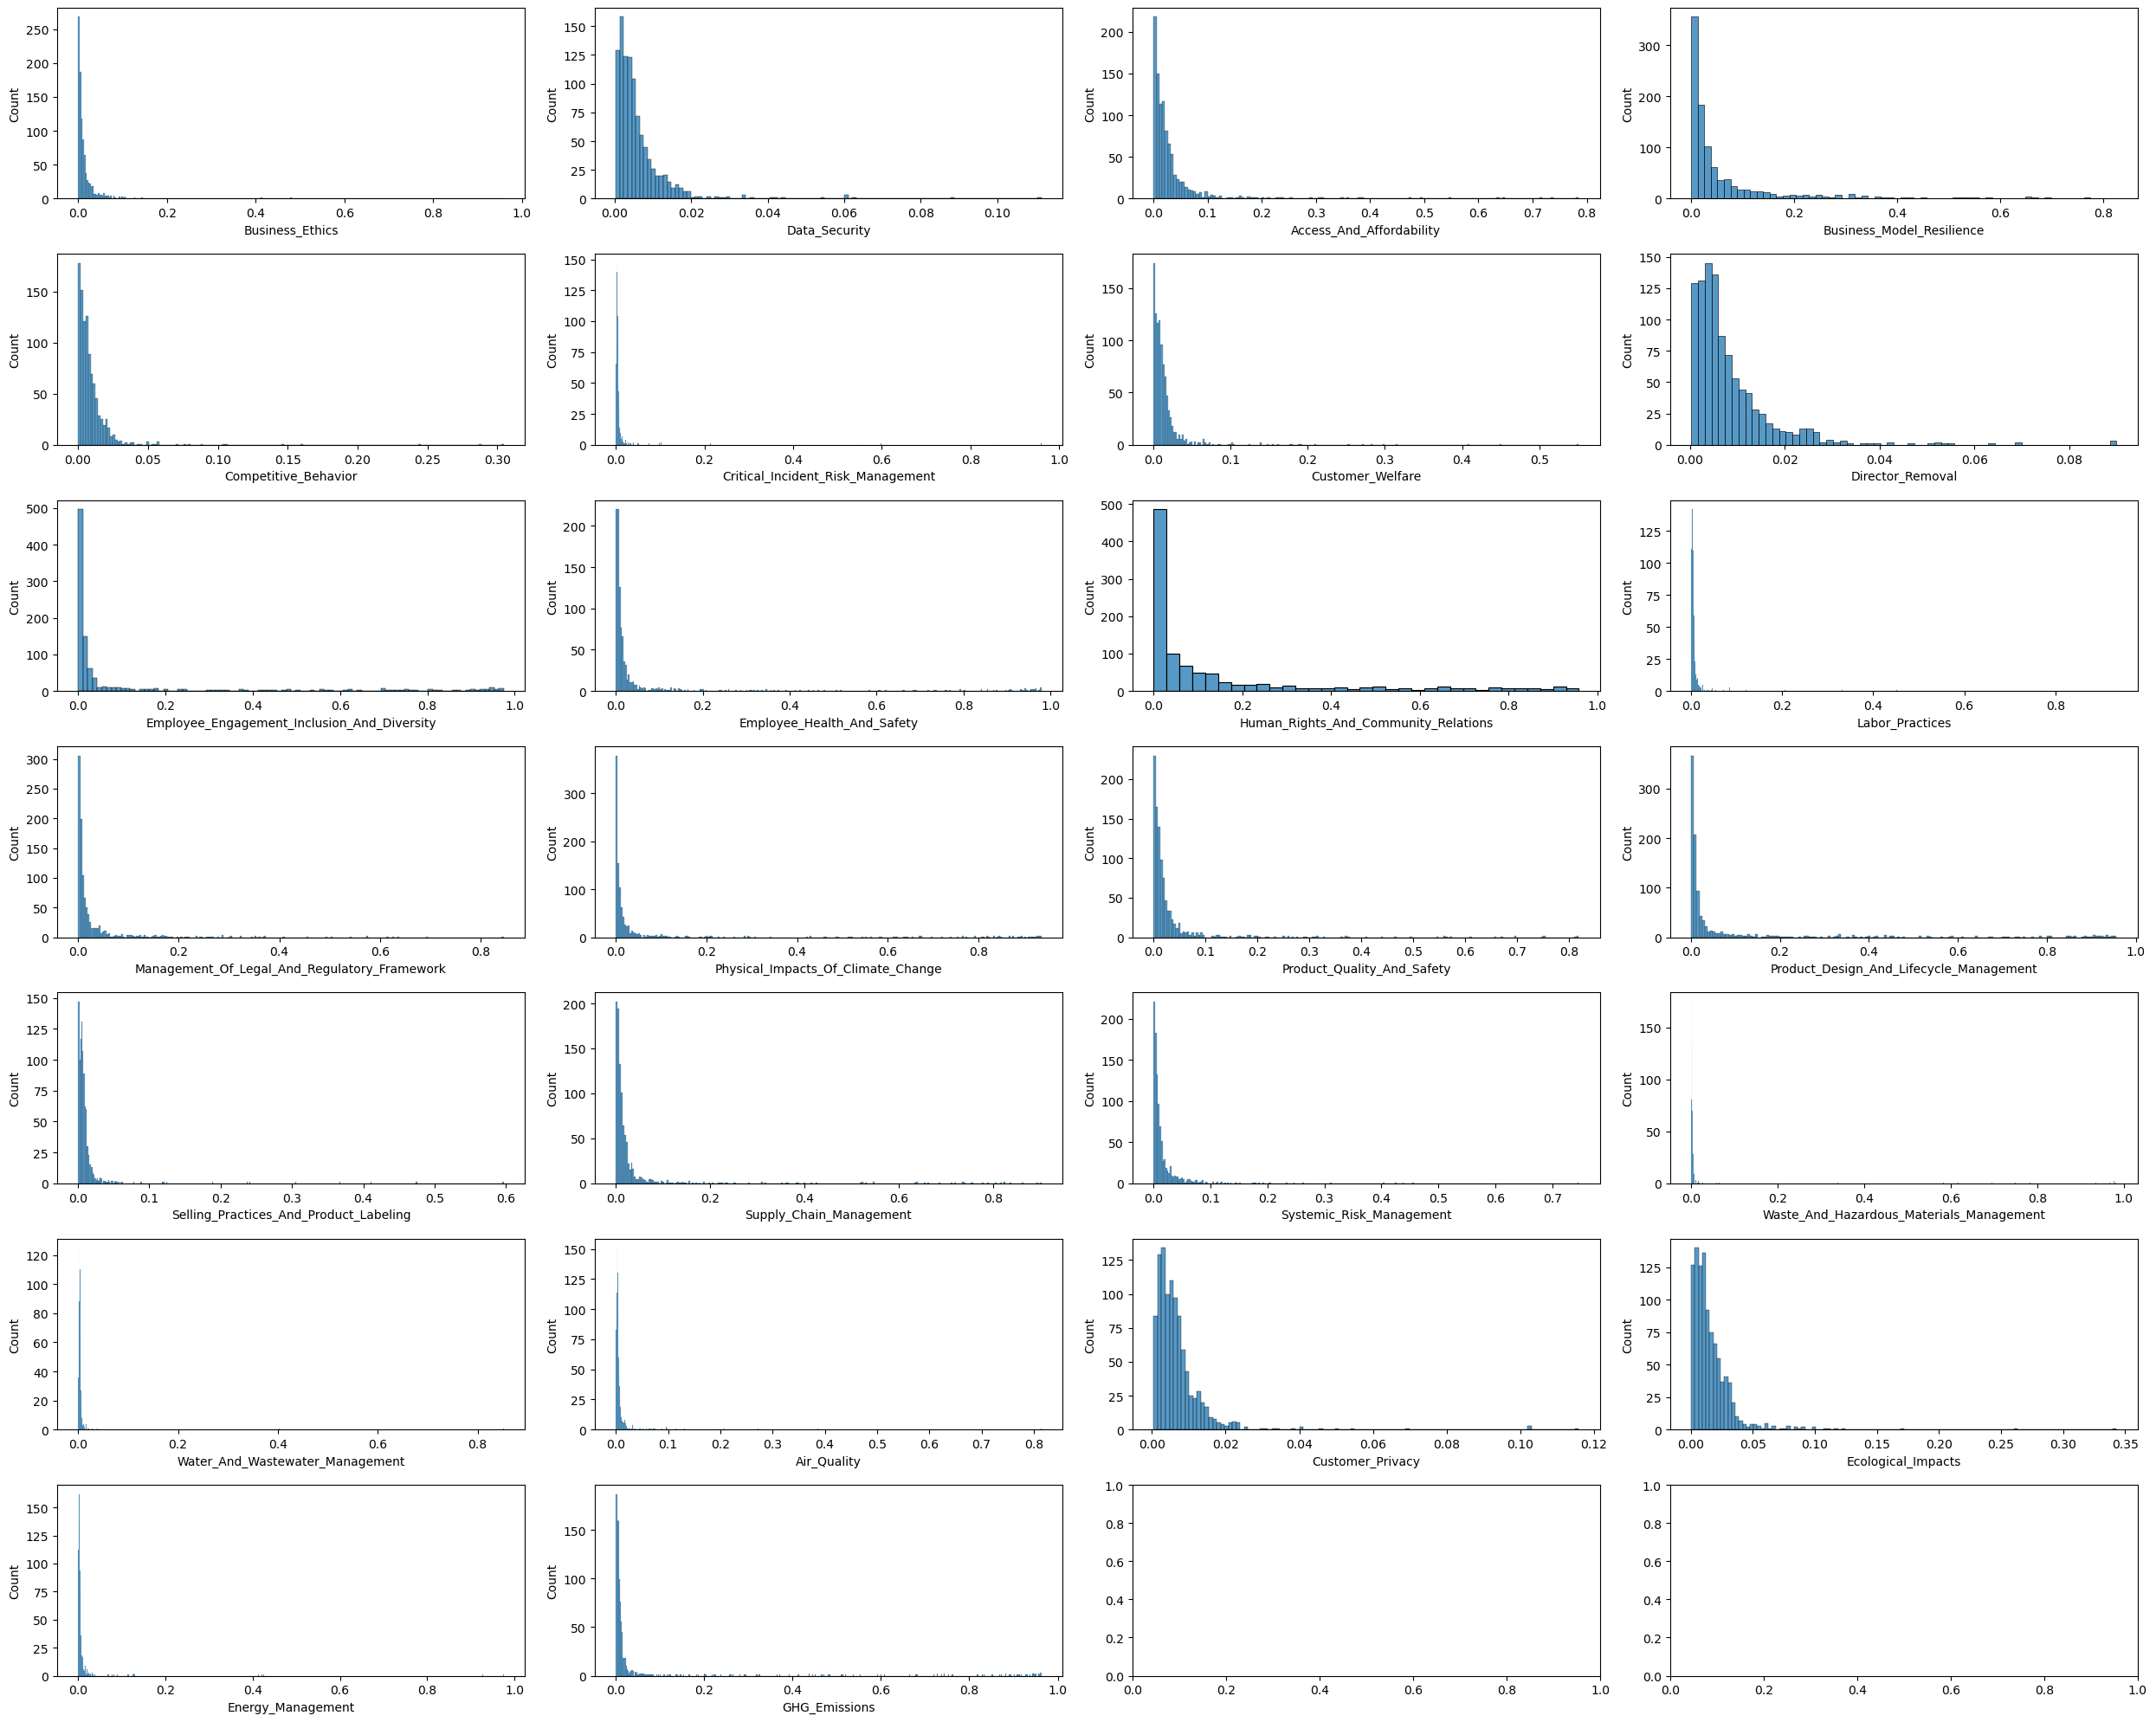

In [290]:
fig, axes = plt.subplots(7, 4, figsize=(25, 20))
i = 0

for ax, column in zip(axes.ravel(), X.columns):
    sns.histplot(data=X, x=column, ax=ax)
    i += 1
    
plt.tight_layout()
plt.show()

There seems to be a big impact from outliers. Let's try and sort out outliers and revisualise. Outliers are taken as any value falling outside the 99th percentile.

In [291]:
def filter_col(col):
    pct_99 = col.quantile(0.99)
    return col[col <= pct_99]

# Apply the filtering to every column in the dataframe
clean_X = X.apply(lambda x: filter_col(x))


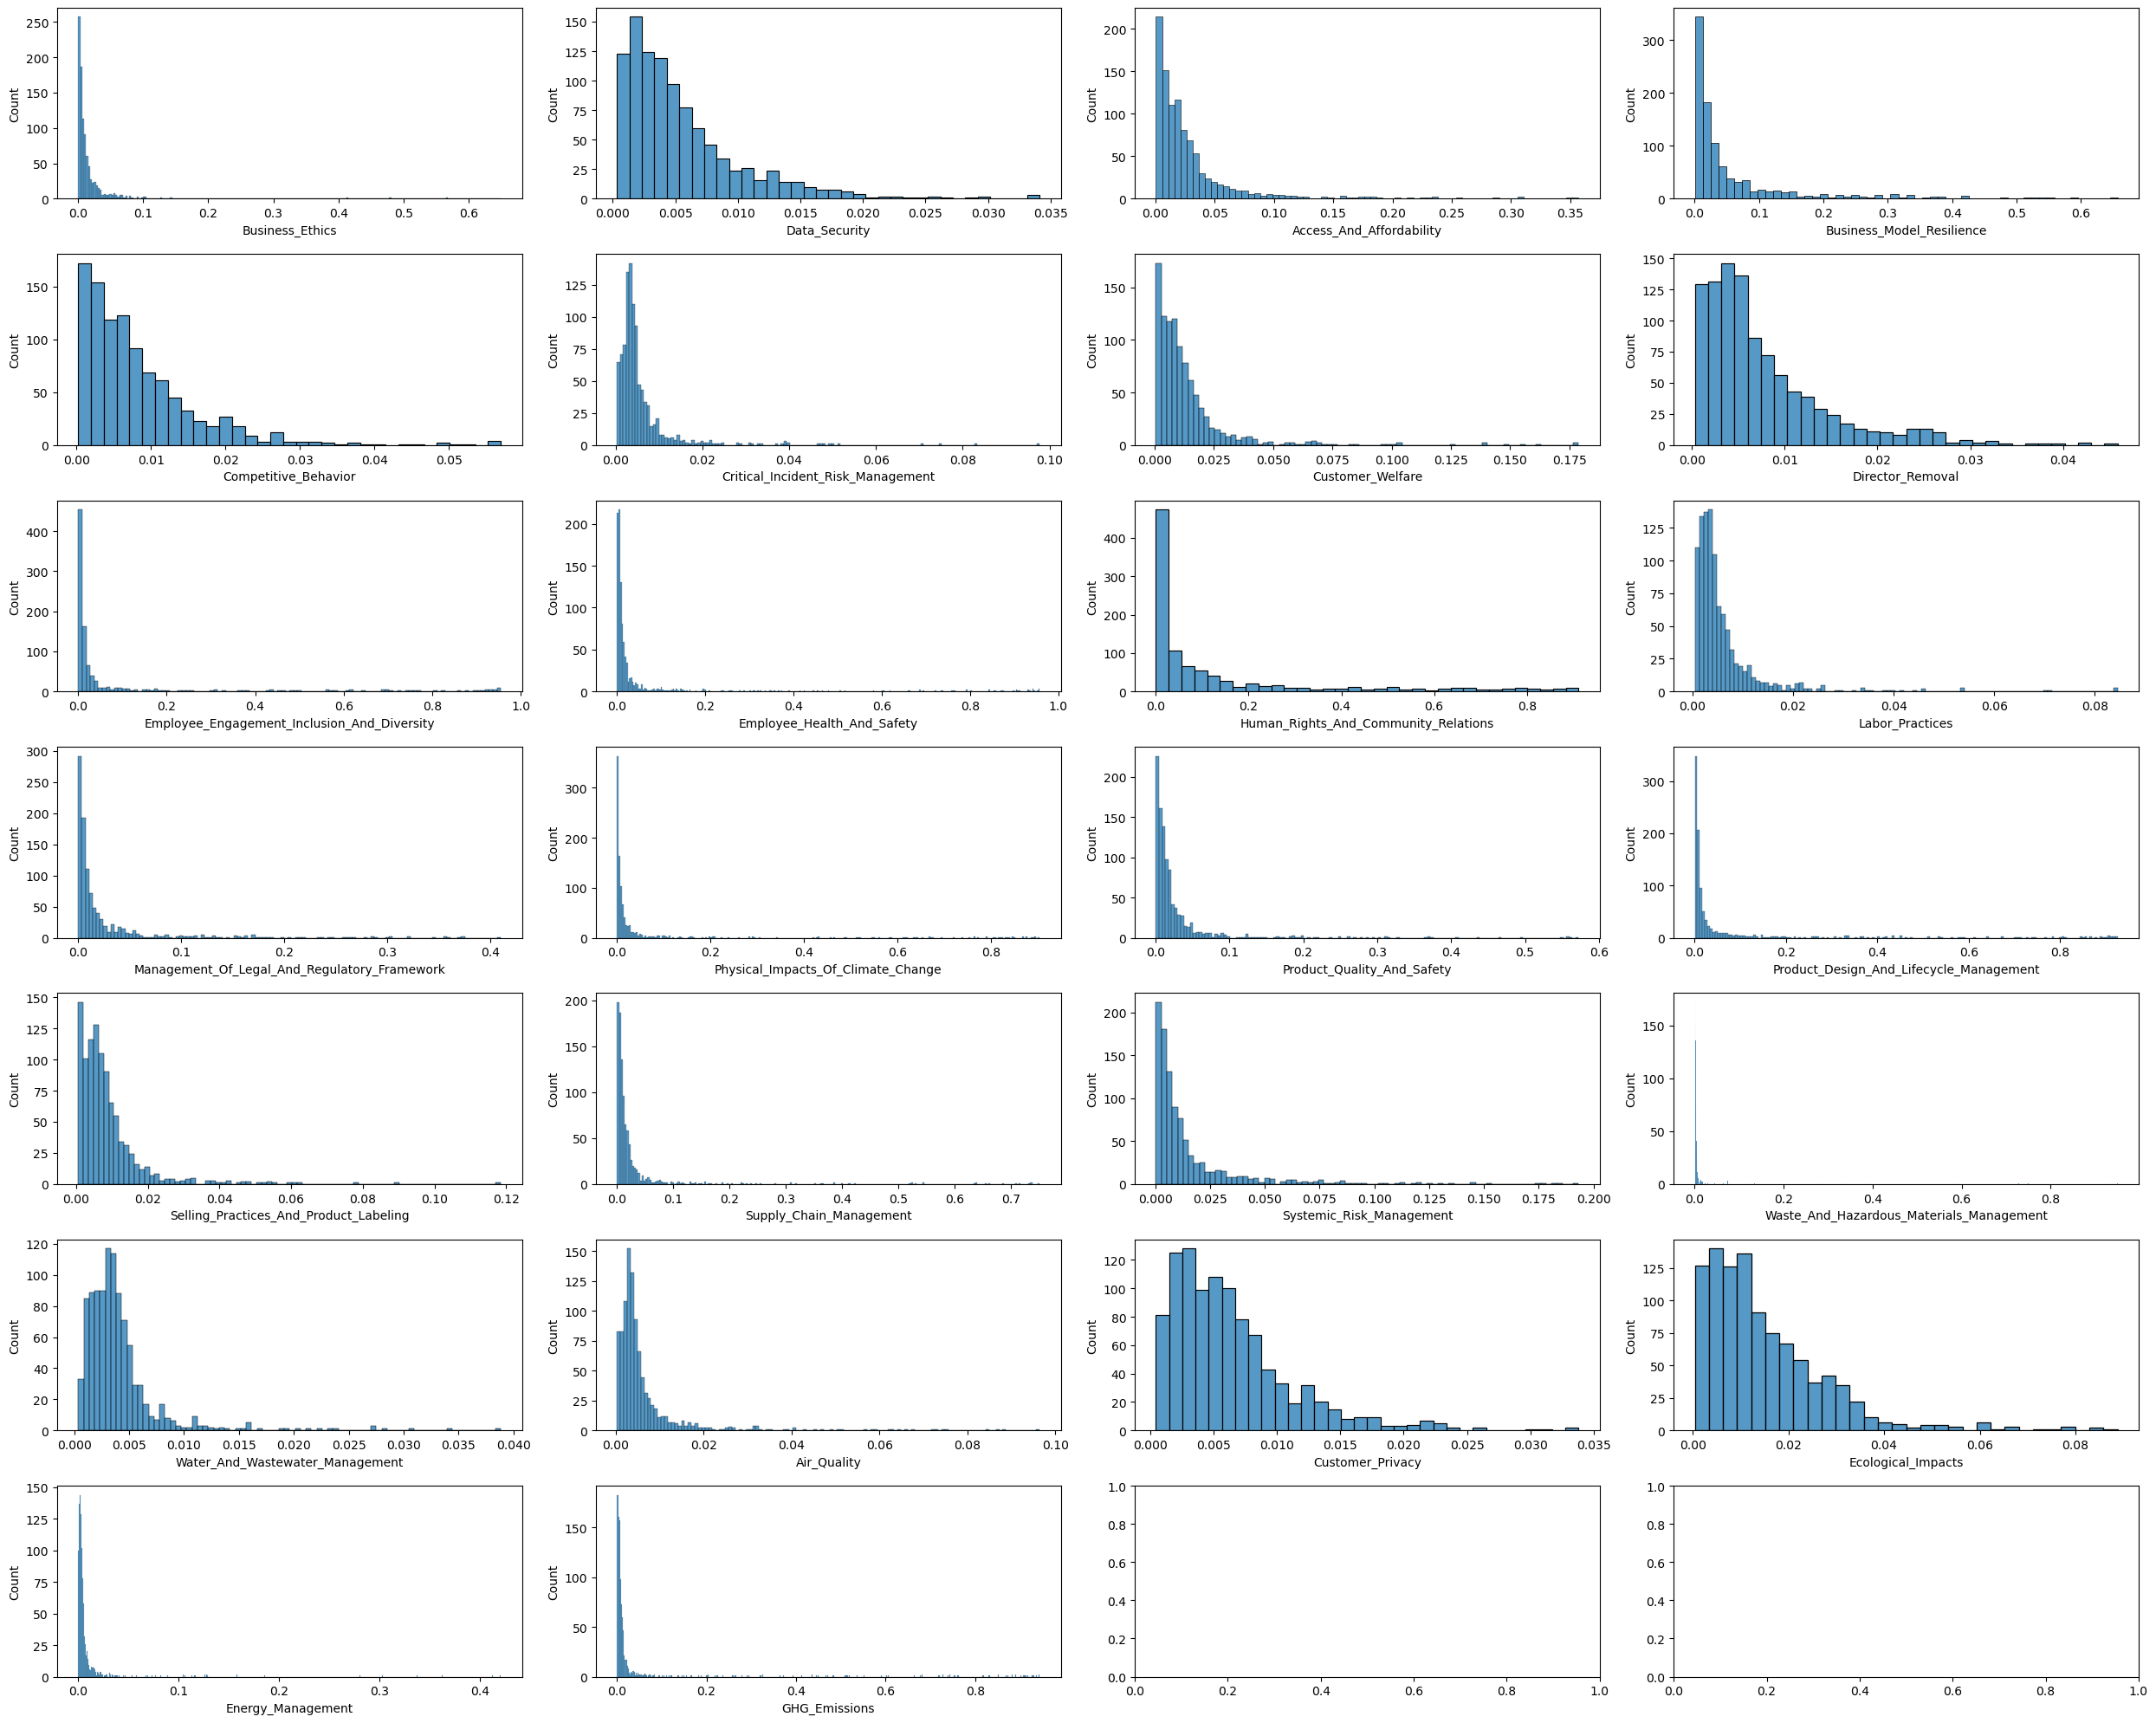

In [292]:
fig, axes = plt.subplots(7, 4, figsize=(25, 20))
i = 0

for ax, column in zip(axes.ravel(), clean_X.columns):
    sns.histplot(data=clean_X, x=column, ax=ax)
    i += 1
    
plt.tight_layout()
plt.show()

There is still heavy skew shown in these distributions. Let's take the log and see what impact this has.

In [293]:
clean_X = X.copy()
for column in clean_X.columns:
    clean_X[column] = np.log(clean_X[column])

In [294]:
clean_X

Business_Ethics  Data_Security  Access_And_Affordability  \
0           -0.245732      -4.665162                 -6.090800   
1           -6.783281      -6.211190                 -6.472647   
2           -5.842409      -5.665886                 -5.206861   
3           -4.936230      -5.811564                 -0.436007   
4           -5.900093      -6.928482                 -4.816281   
...               ...            ...                       ...   
1010        -5.264462      -6.380780                 -4.023568   
1011        -4.826716      -6.379081                 -2.874674   
1012        -5.205482      -6.146753                 -3.822272   
1013        -2.800121      -4.362946                 -3.200591   
1014        -5.705942      -6.110050                 -3.320883   

      Business_Model_Resilience  Competitive_Behavior  \
0                     -4.410056             -4.964292   
1                     -3.678595             -7.533994   
2                     -3.681511             -6.605096   
3                     -4.099046             -4.647750   
4                     -4.018816             -5.923520   
...                         ...                   ...   
1010                  -4.277995             -5.540528   
1011                  -3.858464             -4.570500   
1012                  -5.658012             -5.601900   
1013                  -2.626074             -3.860644   
1014                  -4.807690             -5.716562   

      Critical_Incident_Risk_Management  Customer_Welfare  Director_Removal  \
0                             -5.556061         -5.725894         -3.160031   
1                             -5.954584         -6.905302         -6.170888   
2                             -4.206292         -6.189495         -5.531288   
3                             -4.424032         -2.895151         -6.523936   
4                             -5.848411         -5.437887         -6.216616   
...                                 ...               ...               ...   
1010                          -5.901639         -5.421842         -5.694576   
1011                          -5.150528         -1.207548         -5.315069   
1012                          -4.685591         -5.569084         -6.441262   
1013                          -5.982616         -4.259737         -4.207830   
1014                          -5.750555         -3.444421         -5.461272   

      Employee_Engagement_Inclusion_And_Diversity  Employee_Health_And_Safety  \
0                                       -4.879381                   -5.271186   
1                                       -6.484353                   -6.784769   
2                                       -6.578312                   -5.160457   
3                                       -4.368928                   -4.640721   
4                                       -5.665816                   -6.035857   
...                                           ...                         ...   
1010                                    -5.196699                   -5.335137   
1011                                    -4.399255                   -4.197889   
1012                                    -3.159010                   -0.217521   
1013                                    -1.720225                   -4.917645   
1014                                    -5.107408                   -3.449590   

      ...  Selling_Practices_And_Product_Labeling  Supply_Chain_Management  \
0     ...                               -5.173799                -5.574842   
1     ...                               -6.890335                -5.326220   
2     ...                               -5.570473                -4.813379   
3     ...                               -3.734175                -4.591055   
4     ...                               -6.029756                -4.985980   
...   ...                                     ...                      ...   
1010  ...                               -5.619308           

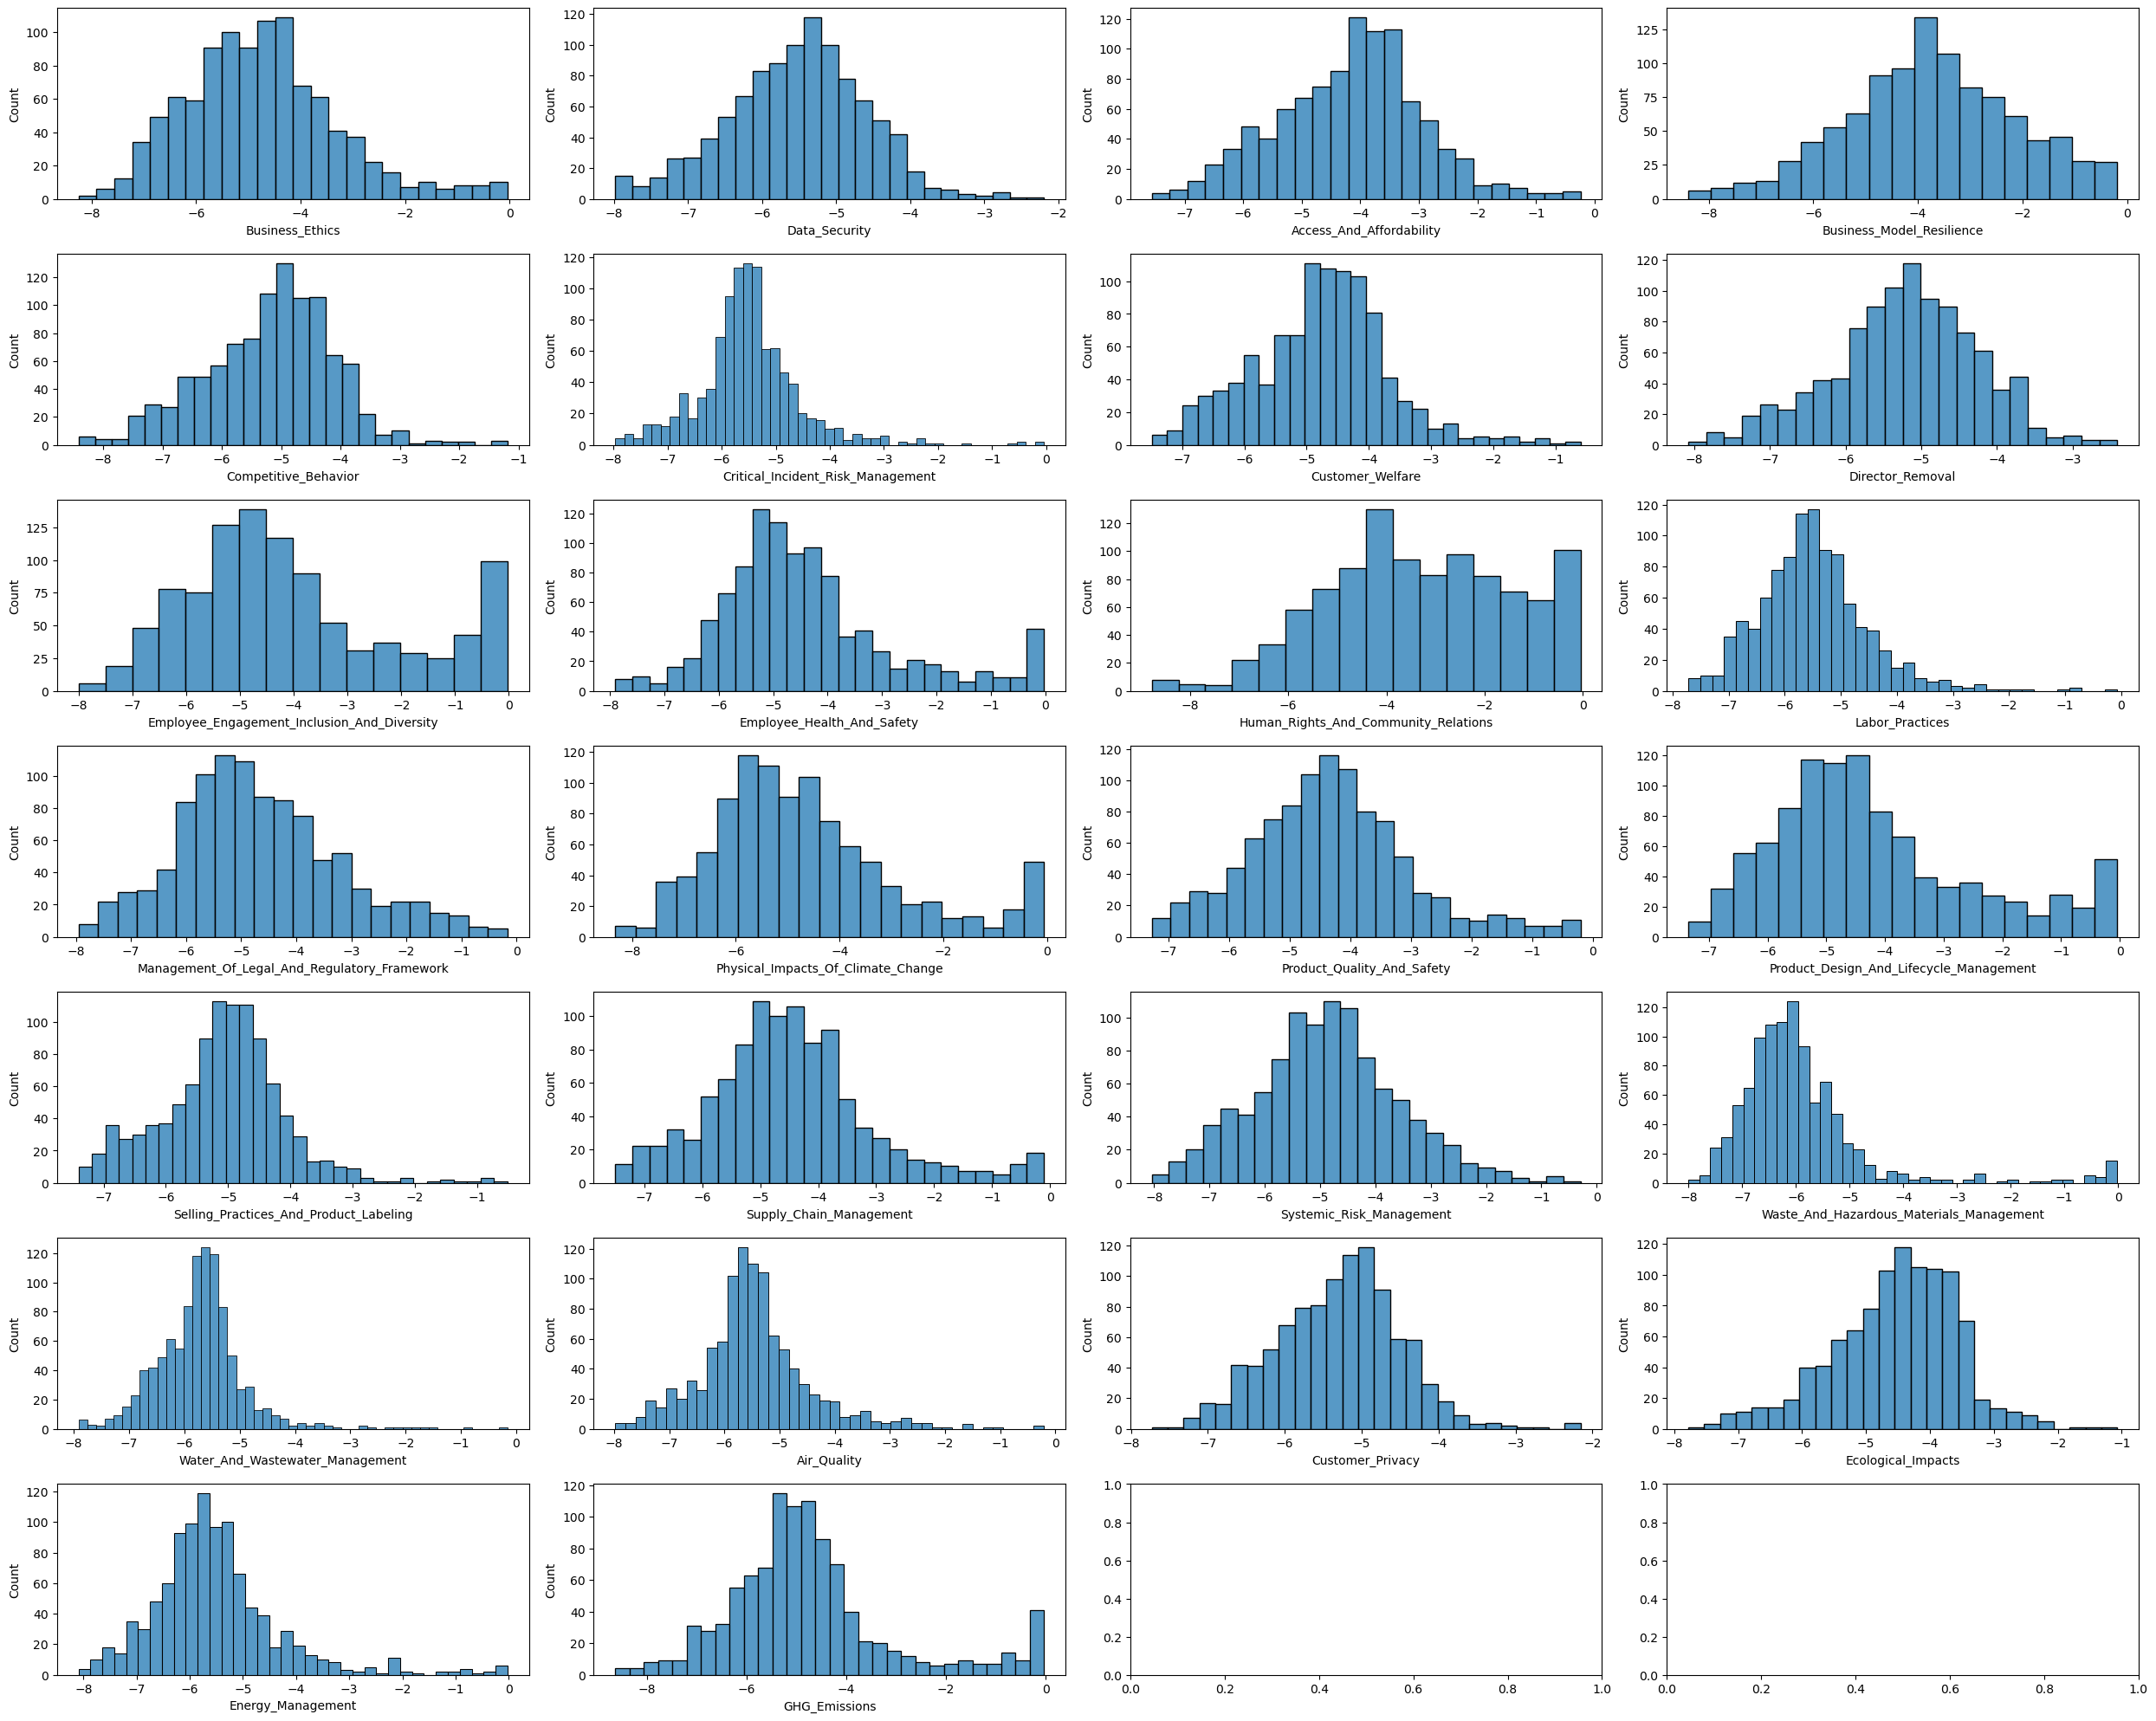

In [295]:
fig, axes = plt.subplots(7, 4, figsize=(25, 20))
i = 0

for ax, column in zip(axes.ravel(), clean_X.columns):
    sns.histplot(data=clean_X, x=column, ax=ax)
    i += 1
    
plt.tight_layout()
plt.show()

We now see some normal distributions. However, the data now needs to be scaled.

In [296]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(clean_X)
clean_X = scaler.transform(clean_X)

In [297]:
clean_X = pd.DataFrame(clean_X, columns=X.columns)

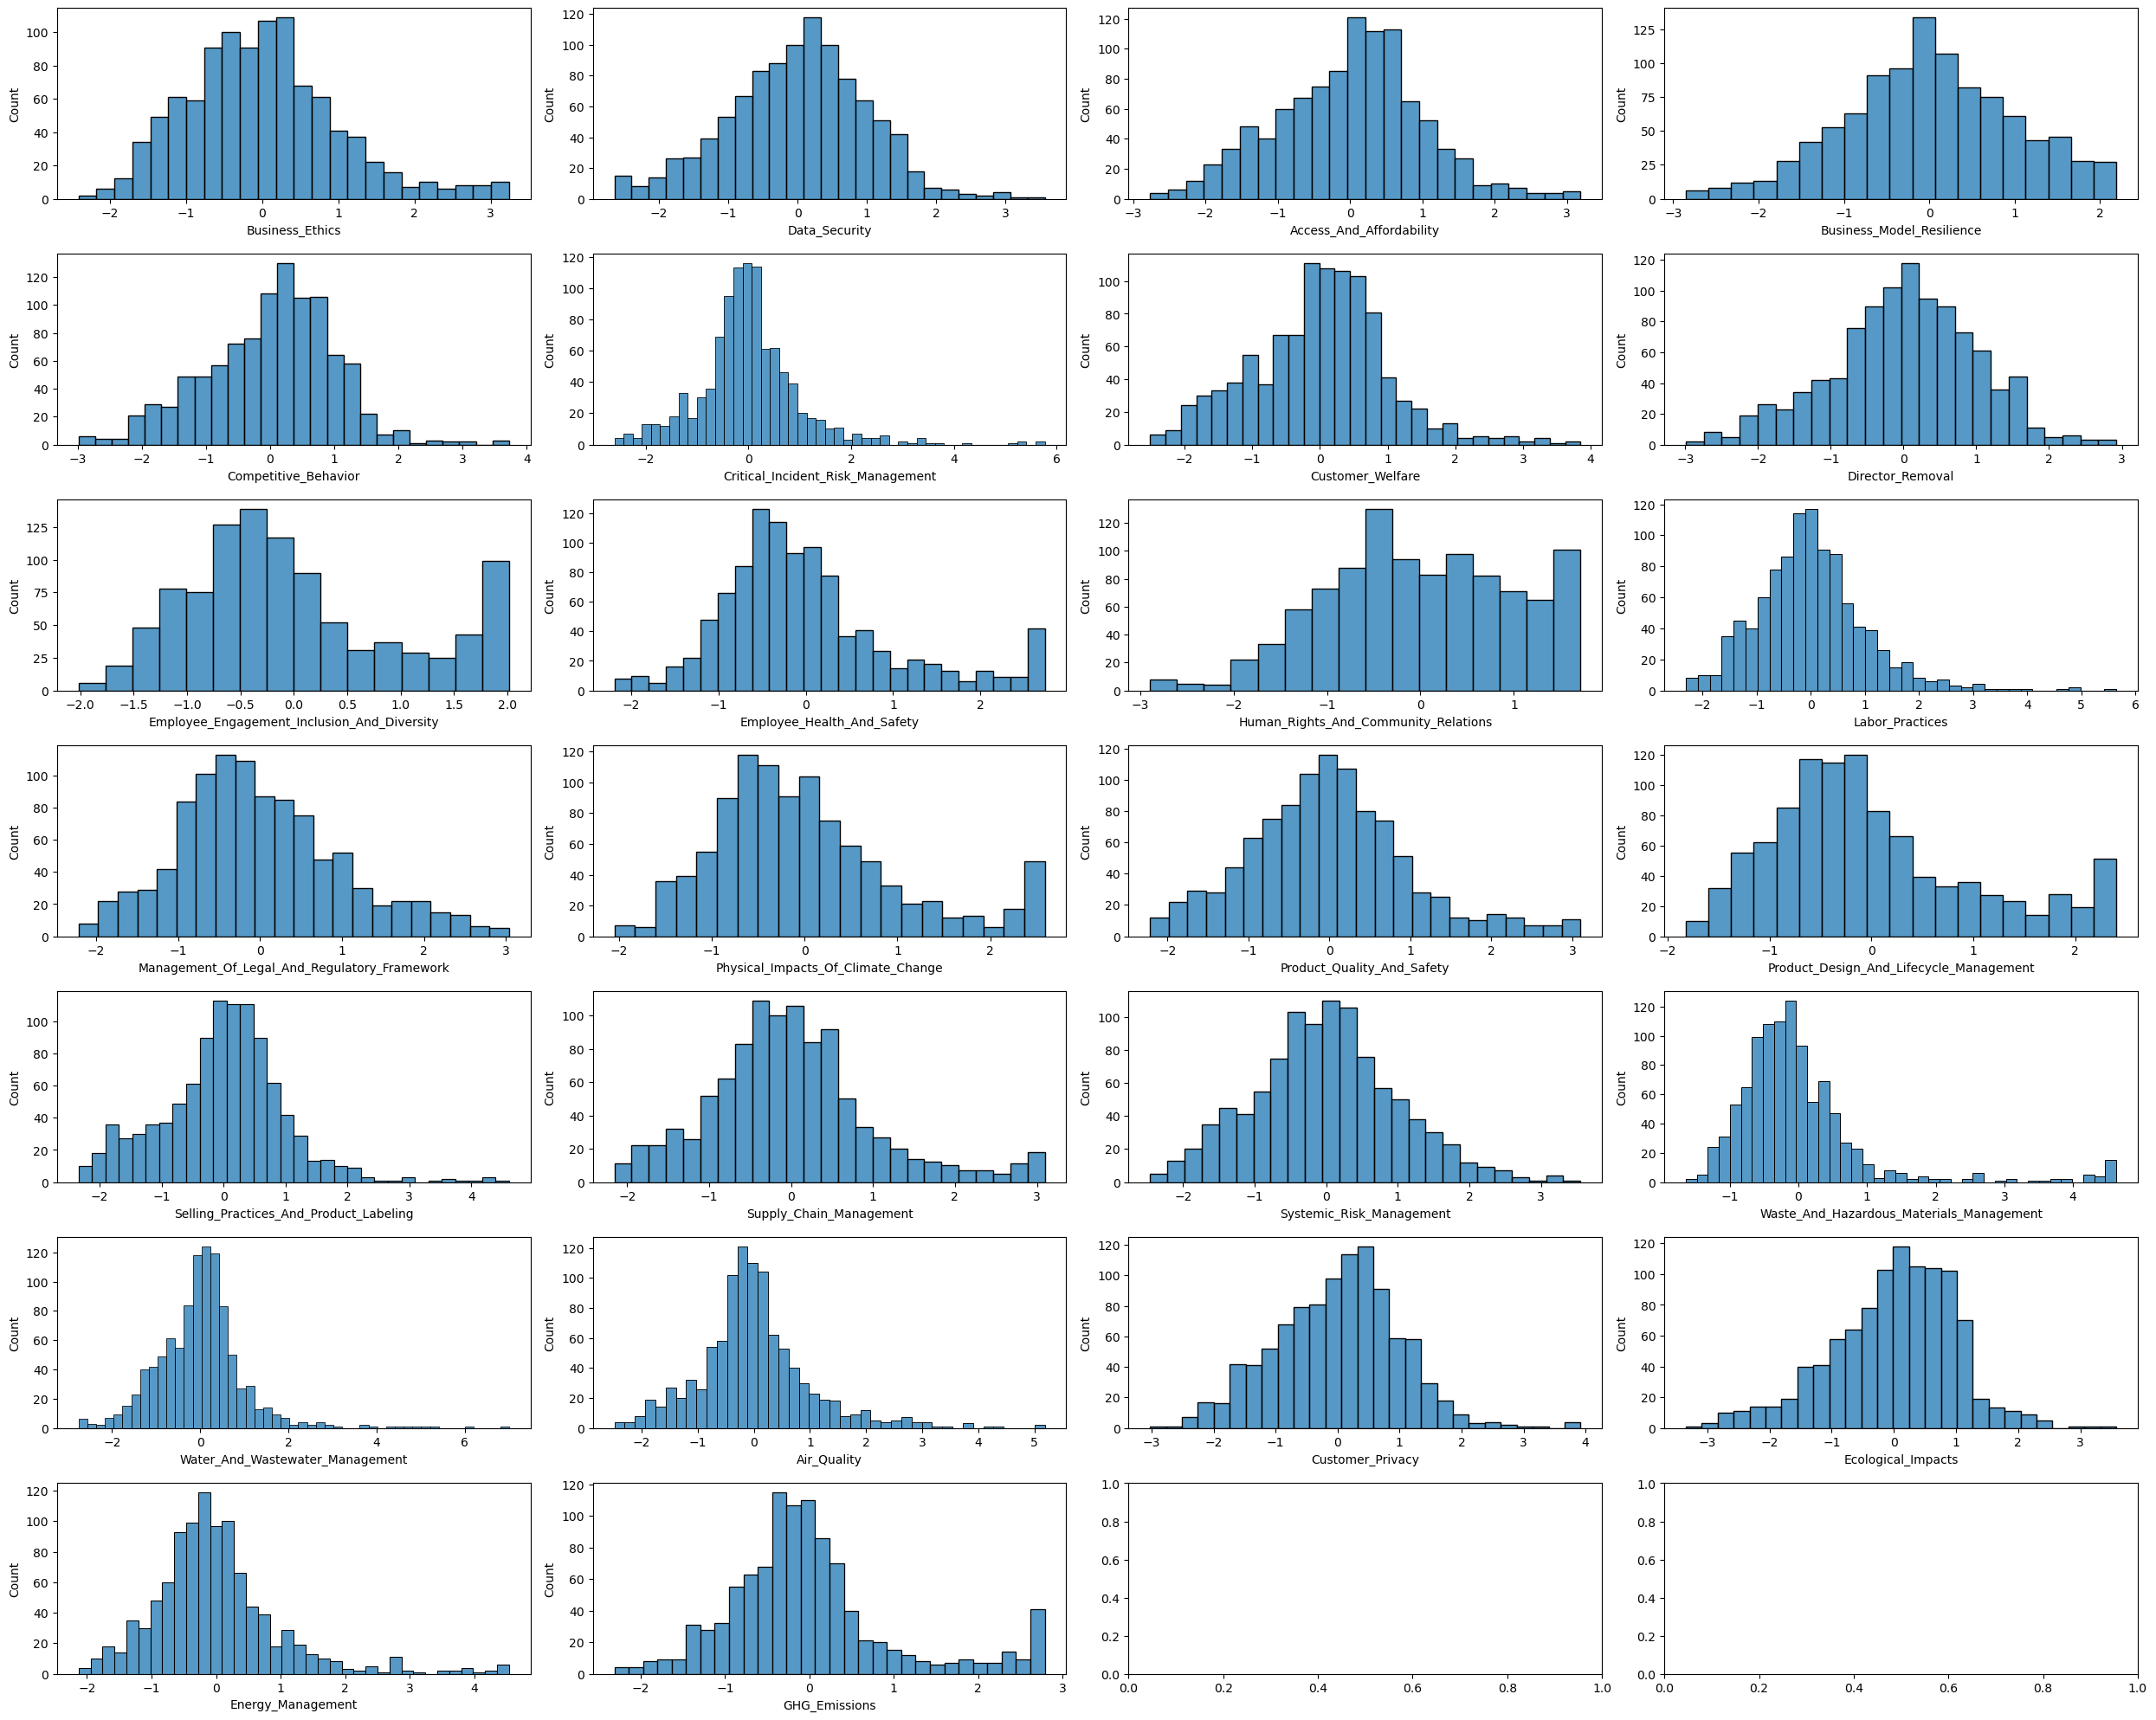

In [298]:
fig, axes = plt.subplots(7, 4, figsize=(25, 20))
i = 0

for ax, column in zip(axes.ravel(), clean_X.columns):
    sns.histplot(data=clean_X, x=column, ax=ax)
    i += 1
    
plt.tight_layout()
plt.show()

The data has been scaled and now is roughly normally distributed.

In [299]:
#rename column names for future reminder

clean_X = pd.DataFrame(data=clean_X.values, columns=[f'log_{column.lower()}' for column in clean_X.columns])

In [300]:
clean_X

log_business_ethics  log_data_security  log_access_and_affordability  \
0                3.099501           0.916371                     -1.570171   
1               -1.397404          -0.742088                     -1.880686   
2               -0.750218          -0.157128                     -0.851357   
3               -0.126895          -0.313400                      3.028275   
4               -0.789896          -1.511543                     -0.533739   
...                   ...                ...                           ...   
1010            -0.352673          -0.924010                      0.110891   
1011            -0.051566          -0.922188                      1.045164   
1012            -0.312103          -0.672965                      0.274583   
1013             1.342444           1.240565                      0.780131   
1014            -0.656348          -0.633593                      0.682310   

      log_business_model_resilience  log_competitive_behavior  \
0                         -0.404855                  0.217634   
1                          0.044811                 -2.168885   
2                          0.043018                 -1.306204   
3                         -0.213662                  0.511612   
4                         -0.164340                 -0.673214   
...                             ...                       ...   
1010                      -0.323671                 -0.317524   
1011                      -0.065764                  0.583354   
1012                      -1.172036                 -0.374521   
1013                       0.691848                  1.242608   
1014                      -0.649301                 -0.481010   

      log_critical_incident_risk_management  log_customer_welfare  \
0                                 -0.061260             -0.880848   
1                                 -0.482534             -1.968292   
2                                  1.365561             -1.308300   
3                                  1.135391              1.729167   
4                                 -0.370300             -0.615299   
...                                     ...                   ...   
1010                              -0.426566             -0.600505   
1011                               0.367423              3.285178   
1012                               0.858901             -0.736266   
1013                              -0.512166              0.470984   
1014                              -0.266857              1.222726   

      log_director_removal  log_employee_engagement_inclusion_and_diversity  \
0                 2.140404                                        -0.437016   
1                -0.999126                                        -1.247978   
2                -0.332192                                        -1.295454   
3                -1.367263                                        -0.179094   
4                -1.046809                                        -0.834387   
...                    ...                                              ...   
1010             -0.502459                                        -0.597351   
1011             -0.106733                                        -0.194418   
1012             -1.281055                                         0.432254   
1013              1.047826                                         1.159244   
1014             -0.259183                                        -0.552234   

      log_employee_health_and_safety  ...  \
0                          -0.543585  ...   
1                          -1.489536  ...   
2                          -0.474382  ...   
3                          -0.149560  ...   
4                          -1.021485  ...   
...                              ...  ...   
1010                       -0.583552  ...   
1011                        0.127199  ...   
1012                        2.614829  ...   
1013                       -0.322631  ...   
1014           

### PCA

To gain a clearer understanding of if there are potential clusters in the features, PCA is used to distill the 26 features down to 4. This then allows a pairplot to be used to visualise the PCAs and identify any potential clusters.

In [301]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 4)

pca_df = pca.fit_transform(clean_X)

In [302]:
pca_df = pd.DataFrame(pca_df, index = clean_X.index, columns = [f"PC{i+1}" for i in range(pca_df.shape[1])])

In [303]:
pca_df.shape

(1015, 4)

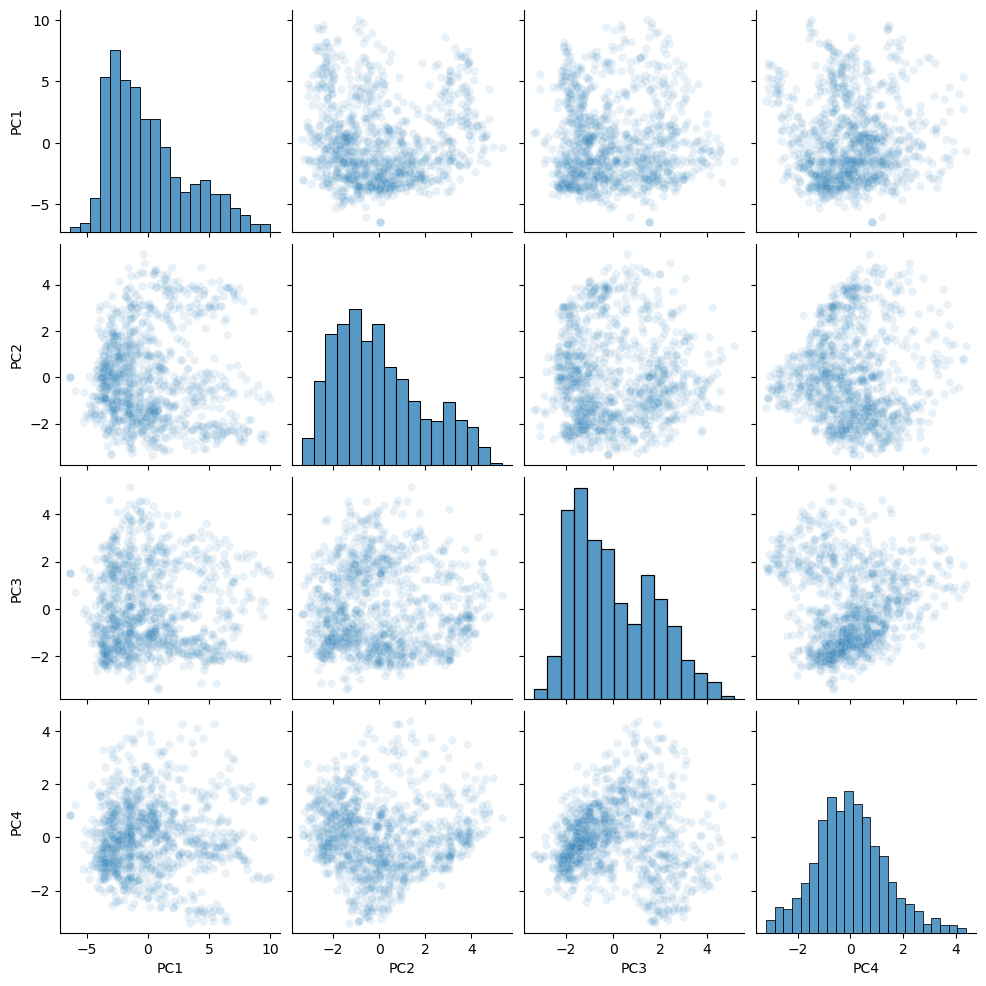

In [304]:
sns.pairplot(pca_df, plot_kws={'alpha':0.1})

PC1 and PC3 could well be bimodal distributions, with two potential peaks to these distributions. Let's see the contributions to PC1,PC2,PC3 and PC4.

<AxesSubplot:title={'center':'Contributions to PC1'}>

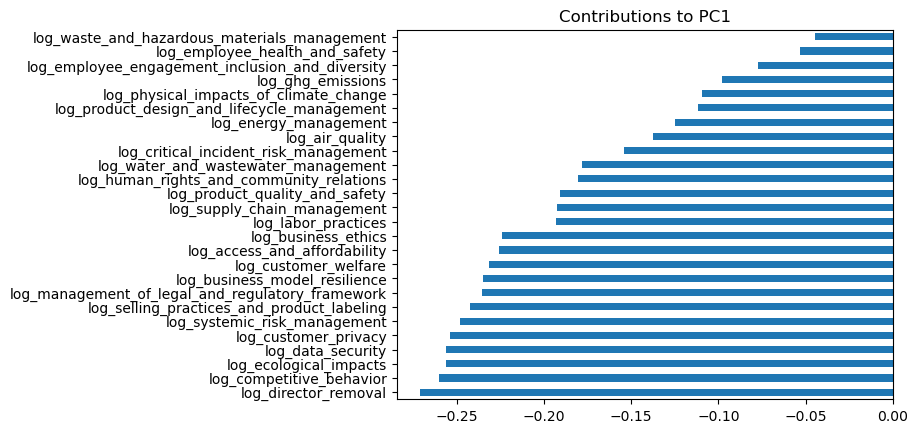

In [305]:
pd.Series(pca.components_[0], index = clean_X.columns).sort_values().plot(kind = 'barh', title = 'Contributions to PC1')


<AxesSubplot:title={'center':'Contributions to PC2'}>

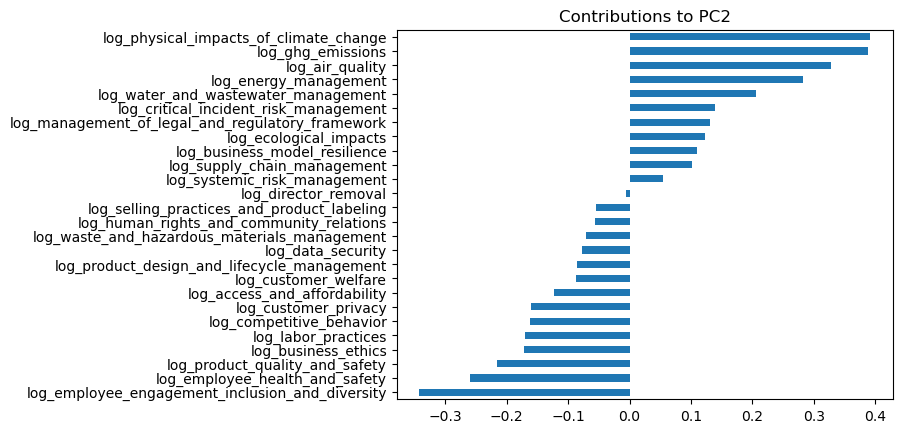

In [306]:
pd.Series(pca.components_[1], index = clean_X.columns).sort_values().plot(kind = 'barh', title = 'Contributions to PC2')

<AxesSubplot:title={'center':'Contributions to PC3'}>

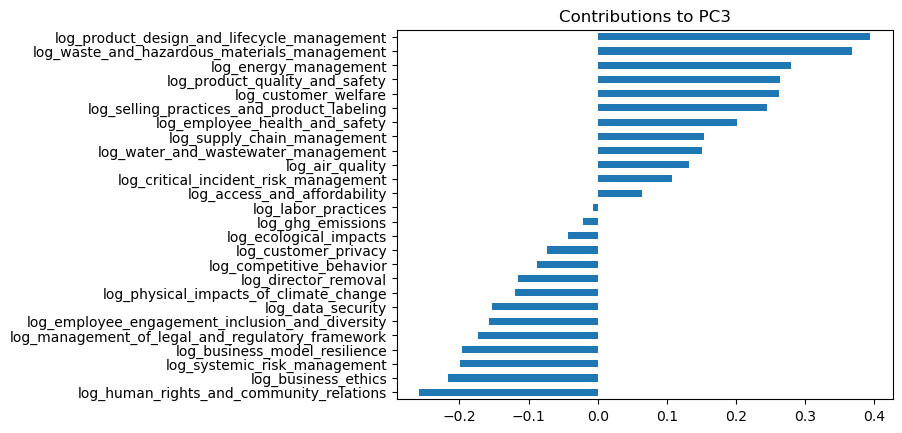

In [307]:
pd.Series(pca.components_[2], index = clean_X.columns).sort_values().plot(kind = 'barh', title = 'Contributions to PC3')

<AxesSubplot:title={'center':'Contributions to PC4'}>

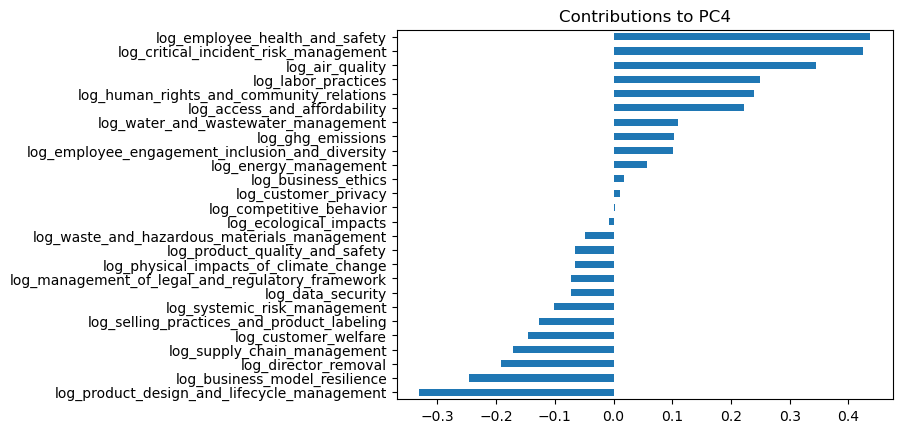

In [308]:
pd.Series(pca.components_[3], index = clean_X.columns).sort_values().plot(kind = 'barh', title = 'Contributions to PC4')

Various different clustering algorithms are now trialled, to see if there are clusters within the data.

# KMeans

In [309]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [310]:
k = 2

kmeans = KMeans(n_clusters = k)
kmeans.fit(clean_X)
labels = kmeans.predict(clean_X)
pca_df['kmeans_labels'] = labels

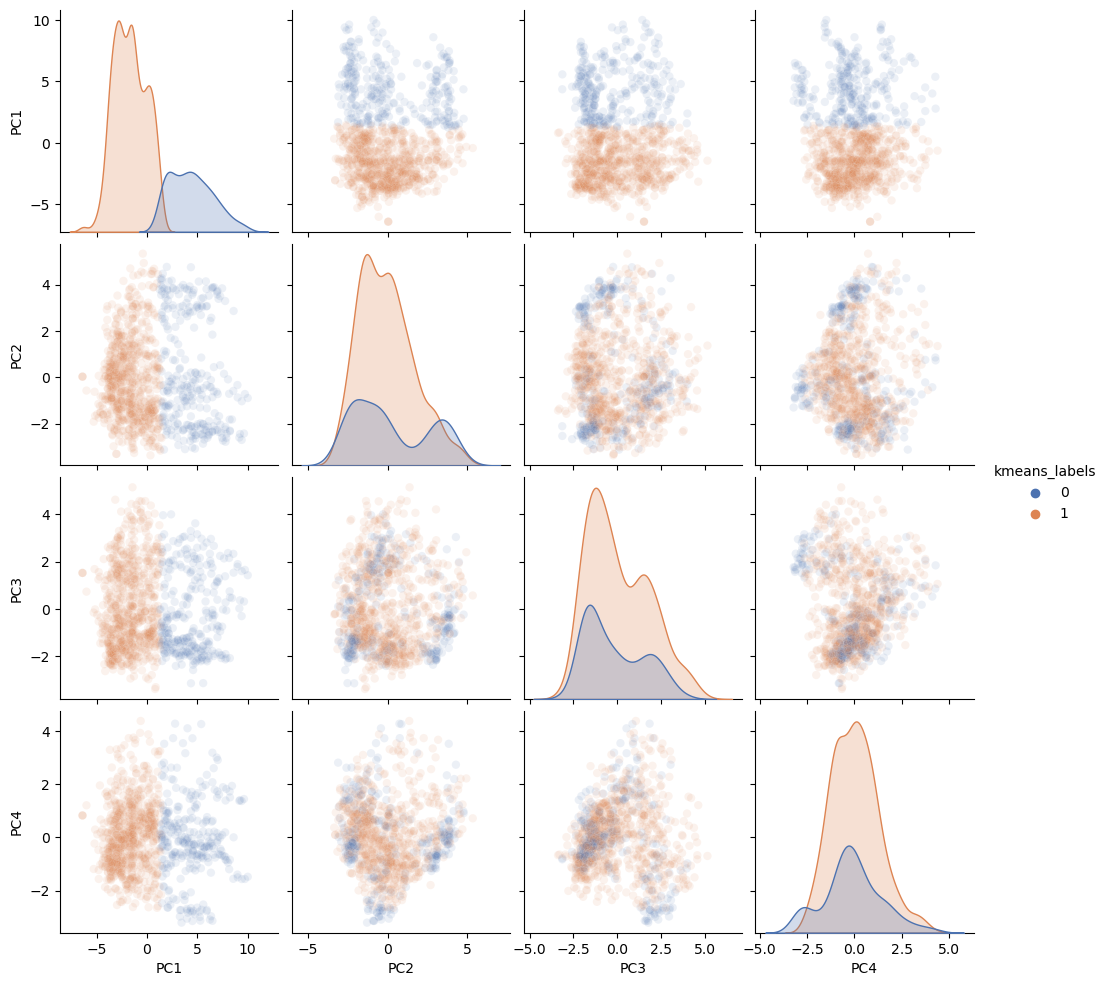

In [311]:
sns.pairplot(pca_df, plot_kws={'alpha':0.1}, hue = 'kmeans_labels', palette='deep')

Interestingly, PC1 seems to split the data into two distributions. Let's iterate through a range of K values to see if there is an optimal value.

In [312]:
results = {
    'inertia': [],
    'silhouette_score': [],
    'num_clusters': [],
    'cluster_size': []
}

for k in range(2, 100):
    
    kmeans = KMeans(n_clusters= k)
    kmeans.fit(clean_X)
    
    labels = kmeans.predict(clean_X)
    results['inertia'].append(kmeans.inertia_)
    results['silhouette_score'].append(silhouette_score(clean_X, labels))
    results['num_clusters'].append(k)
    
    unique_label, counts = np.unique(labels, return_counts=True)
    results['cluster_size'].append(counts)

In [313]:
kmeans_results = pd.DataFrame(results).set_index("num_clusters")
kmeans_results

inertia  silhouette_score  \
num_clusters                                   
2             18720.279000          0.303894   
3             16887.115460          0.184410   
4             15207.283010          0.175283   
5             13883.054214          0.177206   
6             12855.722021          0.184750   
...                    ...               ...   
95             3255.089866          0.184692   
96             3286.208477          0.177210   
97             3275.531461          0.183755   
98             3228.580690          0.181158   
99             3176.771835          0.187568   

                                                   cluster_size  
num_clusters                                                     
2                                                    [284, 731]  
3                                               [495, 227, 293]  
4                                          [343, 133, 382, 157]  
5                                     [148, 225, 119, 231, 292]  
6                                 [140, 203, 258, 88, 140, 186]  
...                                                         ...  
95            [7, 13, 22, 17, 8, 11, 5, 15, 13, 11, 18, 5, 4...  
96            [4, 22, 7, 11, 21, 17, 5, 10, 14, 4, 9, 7, 9, ...  
97            [13, 17, 15, 18, 8, 7, 18, 26, 14, 17, 24, 6, ...  
98            [4, 20, 29, 24, 8, 15, 12, 15, 15, 11, 19, 7, ...  
99            [19, 7, 8, 23, 12, 22, 12, 8, 6, 27, 11, 16, 4...  

[98 rows x 3 columns]

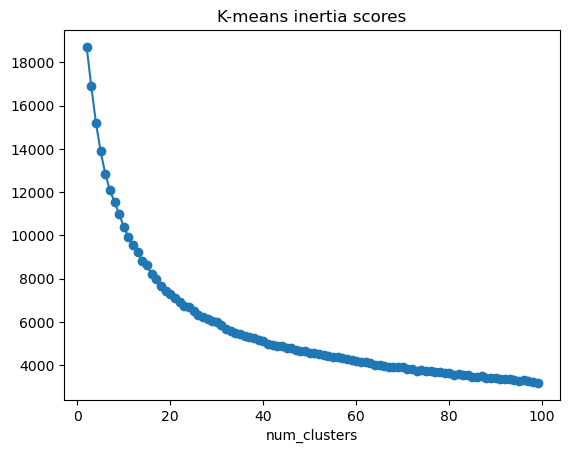

In [314]:
kmeans_results["inertia"].plot(marker="o", title="K-means inertia scores")
plt.show()

No clear elbow...

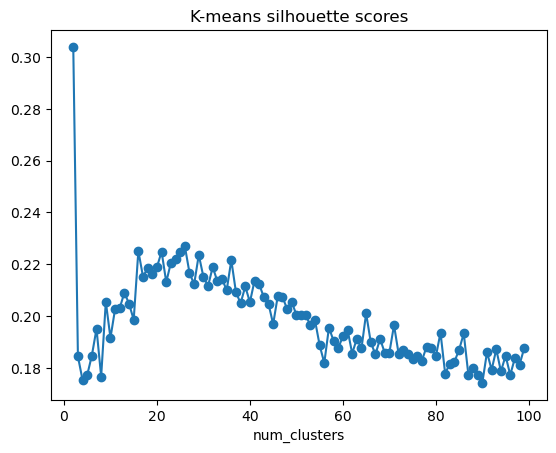

In [315]:
kmeans_results["silhouette_score"].plot(marker="o", title="K-means silhouette scores")
plt.show()

There is a sudden drop in silhouette score after the number of clusters increases from 2. Hence, 2 seems a good number of clusters.

### DBScan

In [316]:
from sklearn.cluster import DBSCAN

In [317]:
epsilon = 2
min_samples = 5

dbscan = DBSCAN(eps = epsilon, min_samples = min_samples)
labels = dbscan.fit_predict(clean_X)

is_noise = labels == -1
is_not_noise = labels != -1

non_noise_labels = labels[is_not_noise]

print('Number of noise points: ', is_noise.sum())

unique_labels, counts = np.unique(non_noise_labels, return_counts = True)

print('Number of clusters: ', len(counts))
print("Size of clusters: ", counts)

Number of noise points:  378
Number of clusters:  8
Size of clusters:  [520  20  41  12   9  11  19   5]


We have identified 8 clusters, but most belong in a single cluster - not helpful.

In [318]:
eps_range = np.arange(0.5, 2.01, 0.05)
min_samples_range = [5, 10, 20, 50]

In [319]:
results = {
    'eps': [],
    'silhouette_score': [],
    'num_clusters': [],
    'cluster_size': [],
    'noise_points': [],
    'min_samples' : []
}

for epsilon in eps_range:
    for min_samples in min_samples_range:

        dbscan = DBSCAN(eps = epsilon, min_samples = min_samples)
        labels = dbscan.fit_predict(clean_X)

        is_noise = labels == -1
        is_not_noise = labels != -1
        
        non_noise_labels = labels[is_not_noise]
        unique_labels, counts = np.unique(non_noise_labels, return_counts = True)
        
        if len(counts) <= 1:
            results['silhouette_score'].append(np.nan)
        else:
            results['silhouette_score'].append(silhouette_score(clean_X[is_not_noise], labels[is_not_noise]))
            
        results['eps'].append(epsilon)
        results['min_samples'].append(min_samples)
        results['num_clusters'].append(len(counts))
        results['cluster_size'].append(counts)
        results['noise_points'].append(is_noise.sum())

In [320]:
dbscan_results = pd.DataFrame(results).sort_values(by='silhouette_score', ascending = False).head(20)

In [321]:
dbscan_results['eps'] = dbscan_results['eps'].round(2)

In [322]:
dbscan_results.head(5)

eps  silhouette_score  num_clusters      cluster_size  noise_points  \
24  0.80          0.859275             3         [8, 5, 6]           996   
78  1.45          0.739287             2          [24, 21]           970   
28  0.85          0.721381             5   [8, 5, 5, 6, 5]           986   
61  1.25          0.685772             4  [41, 24, 12, 10]           928   
82  1.50          0.685715             2          [38, 25]           952   

    min_samples  
24            5  
78           20  
28            5  
61           10  
82           20

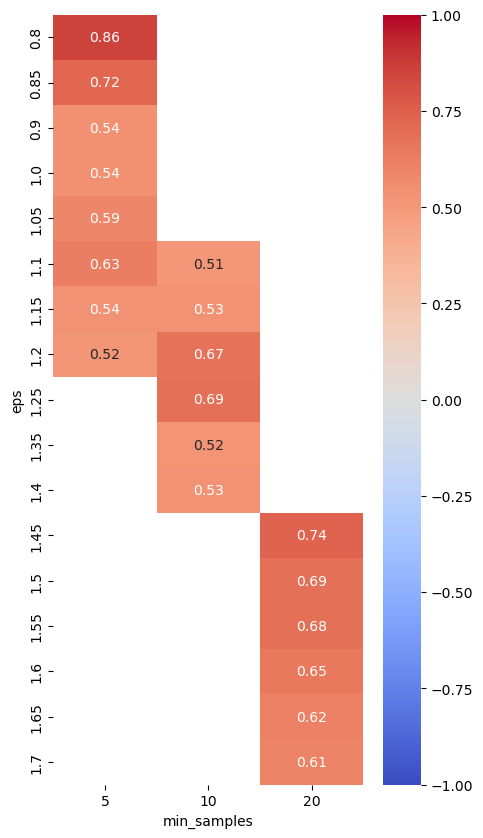

In [323]:
plt.figure(figsize=(5, 10))
sns.heatmap(
    pd.pivot(dbscan_results, index="eps", columns="min_samples", values="silhouette_score"),
    vmin=-1, vmax=1, cmap="coolwarm", annot=True,
)
plt.show()

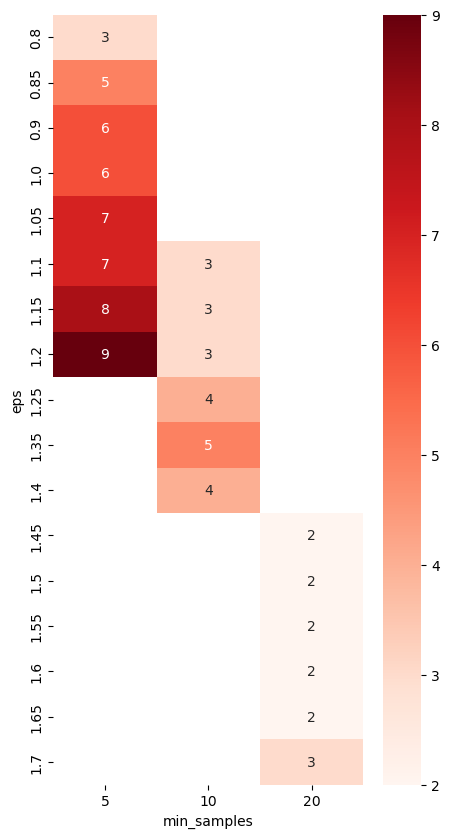

In [324]:
plt.figure(figsize=(5, 10))
sns.heatmap(
    pd.pivot(dbscan_results, index="eps", columns="min_samples", values="num_clusters"), 
    cmap="Reds", annot=True,
)
plt.show()

From the above, the optimal silhouette score is when 5 samples per grouping, and an epsilon = 0.8. This results in 3 clusters interestingly. 

Checking our PCA plots with the optimal DBSCAN parameters...

In [325]:
eps, min_samples = 0.8, 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(clean_X)

pca_df[f"dbscan_eps{eps}_min_samples{min_samples}"] = labels

### EVALUATE ###

is_noise = labels == -1
not_noise = labels != -1

non_noise_labels = labels[not_noise]

print("Number of noise points: ", is_noise.sum())

unqiue_labels, counts = np.unique(non_noise_labels, return_counts=True)

print("Number of clusters: ", len(counts))
print("Cluster sizes: ", counts)

Number of noise points:  996
Number of clusters:  3
Cluster sizes:  [8 5 6]


In [326]:
pca_df

PC1       PC2       PC3       PC4  kmeans_labels  \
0    -0.496820 -1.351891 -2.585393 -0.674475              1   
1     5.350309  2.687809 -2.202633 -1.159077              0   
2     0.992985  4.056741 -0.388300  1.429173              1   
3    -1.442612  0.150752  2.293191  0.810149              1   
4     2.252657  3.552034 -0.352325  0.542097              0   
...        ...       ...       ...       ...            ...   
1010  1.420445  0.808476 -1.457590  0.492148              0   
1011 -2.138954 -0.587166  3.578690 -0.856971              1   
1012  2.398356 -2.277525 -0.046735  2.629189              0   
1013 -3.038229 -1.388581 -1.672122 -0.376115              1   
1014  0.171412 -1.189448  3.573317 -1.093170              1   

      dbscan_eps0.8_min_samples5  
0                             -1  
1                             -1  
2                             -1  
3                             -1  
4                             -1  
...                          ...  
1010                          -1  
1011                          -1  
1012                          -1  
1013                          -1  
1014                          -1  

[1015 rows x 6 columns]

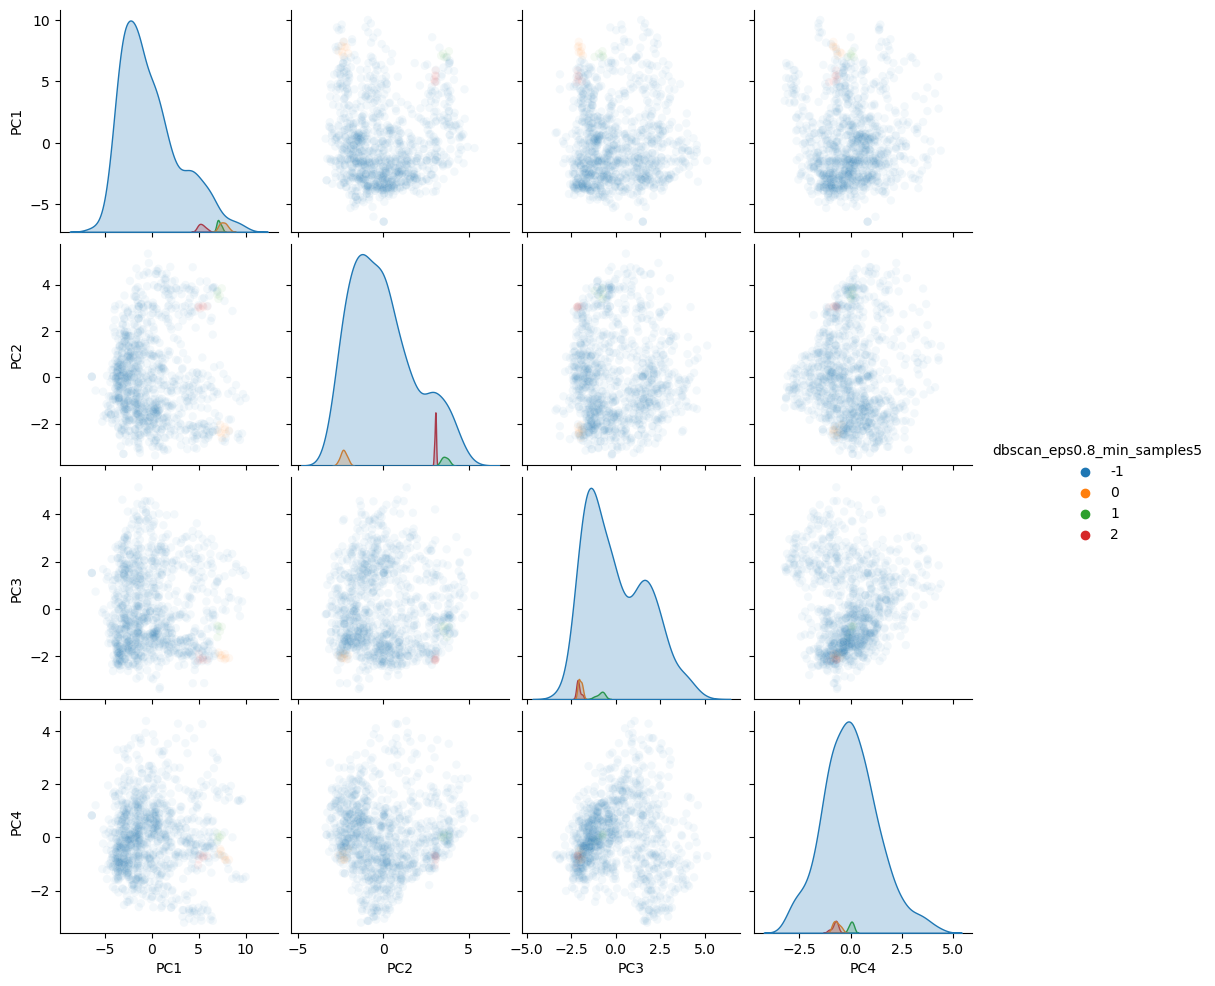

In [327]:
sns.pairplot(pca_df[["PC1", "PC2", "PC3", "PC4", "dbscan_eps0.8_min_samples5"]], 
             plot_kws={"alpha": 0.05}, 
             hue="dbscan_eps0.8_min_samples5",
            palette="tab10")
plt.show()

DBScan is not helpful as there do not appear to be any sparse areas between our data points. The clusters identified are tiny, with the majority of data classified as noise (blue in the above plots).

### Hierarchical Clustering

In [328]:
from sklearn.cluster import AgglomerativeClustering

In [329]:
results = {
    "silhoutte_score": [],
    "num_clusters": [],
    "cluster_sizes": []
}

for k in range(2, 10):
    print(f"Working on k={k}...", end="\r")
    
    # fit clustering
    agg_model = AgglomerativeClustering(n_clusters=k)
    labels = agg_model.fit_predict(clean_X)

    # score
    silh_score =silhouette_score(clean_X, labels)
    results["silhoutte_score"].append(silh_score)
    
    # save label info
    results["num_clusters"].append(k)
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    results["cluster_sizes"].append(counts)

In [330]:
agg_results = pd.DataFrame(results).set_index("num_clusters")
agg_results

silhoutte_score                            cluster_sizes
num_clusters                                                          
2                    0.249870                               [293, 722]
3                    0.235308                          [722, 152, 141]
4                    0.127194                     [502, 152, 141, 220]
5                    0.143621                [152, 255, 141, 220, 247]
6                    0.141247             [141, 255, 53, 220, 247, 99]
7                    0.153983          [92, 255, 49, 220, 247, 99, 53]
8                    0.159257      [255, 247, 49, 220, 46, 99, 53, 46]
9                    0.164540  [247, 46, 49, 220, 166, 99, 53, 46, 89]

In [331]:
k = 2
agg_model = AgglomerativeClustering(n_clusters=k)
pca_df[f"agg_k{k}"] = agg_model.fit_predict(clean_X)

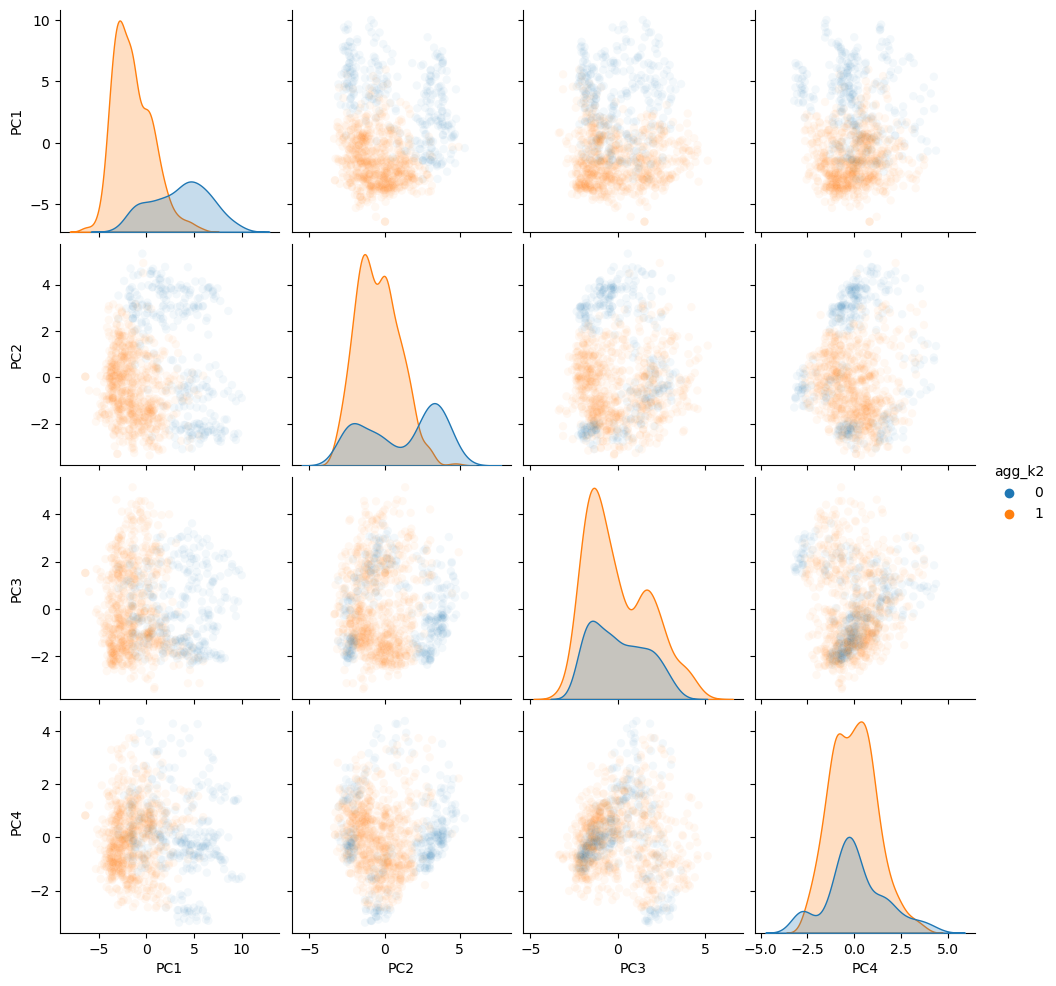

In [332]:
sns.pairplot(pca_df[["PC1", "PC2", "PC3", "PC4", "agg_k2"]], 
             plot_kws={"alpha": 0.05}, 
             hue="agg_k2",
            palette="tab10")
plt.show()

### Findings

KMeans appears to give the two most distinct clusters and is the focus going forward.

In [333]:
pca_df.head()

PC1       PC2       PC3       PC4  kmeans_labels  \
0 -0.496820 -1.351891 -2.585393 -0.674475              1   
1  5.350309  2.687809 -2.202633 -1.159077              0   
2  0.992985  4.056741 -0.388300  1.429173              1   
3 -1.442612  0.150752  2.293191  0.810149              1   
4  2.252657  3.552034 -0.352325  0.542097              0   

   dbscan_eps0.8_min_samples5  agg_k2  
0                          -1       1  
1                          -1       0  
2                          -1       0  
3                          -1       1  
4                          -1       0

In [334]:
clean_X['labels'] = pca_df['kmeans_labels']

In [335]:
clean_X

log_business_ethics  log_data_security  log_access_and_affordability  \
0                3.099501           0.916371                     -1.570171   
1               -1.397404          -0.742088                     -1.880686   
2               -0.750218          -0.157128                     -0.851357   
3               -0.126895          -0.313400                      3.028275   
4               -0.789896          -1.511543                     -0.533739   
...                   ...                ...                           ...   
1010            -0.352673          -0.924010                      0.110891   
1011            -0.051566          -0.922188                      1.045164   
1012            -0.312103          -0.672965                      0.274583   
1013             1.342444           1.240565                      0.780131   
1014            -0.656348          -0.633593                      0.682310   

      log_business_model_resilience  log_competitive_behavior  \
0                         -0.404855                  0.217634   
1                          0.044811                 -2.168885   
2                          0.043018                 -1.306204   
3                         -0.213662                  0.511612   
4                         -0.164340                 -0.673214   
...                             ...                       ...   
1010                      -0.323671                 -0.317524   
1011                      -0.065764                  0.583354   
1012                      -1.172036                 -0.374521   
1013                       0.691848                  1.242608   
1014                      -0.649301                 -0.481010   

      log_critical_incident_risk_management  log_customer_welfare  \
0                                 -0.061260             -0.880848   
1                                 -0.482534             -1.968292   
2                                  1.365561             -1.308300   
3                                  1.135391              1.729167   
4                                 -0.370300             -0.615299   
...                                     ...                   ...   
1010                              -0.426566             -0.600505   
1011                               0.367423              3.285178   
1012                               0.858901             -0.736266   
1013                              -0.512166              0.470984   
1014                              -0.266857              1.222726   

      log_director_removal  log_employee_engagement_inclusion_and_diversity  \
0                 2.140404                                        -0.437016   
1                -0.999126                                        -1.247978   
2                -0.332192                                        -1.295454   
3                -1.367263                                        -0.179094   
4                -1.046809                                        -0.834387   
...                    ...                                              ...   
1010             -0.502459                                        -0.597351   
1011             -0.106733                                        -0.194418   
1012             -1.281055                                         0.432254   
1013              1.047826                                         1.159244   
1014             -0.259183                                        -0.552234   

      log_employee_health_and_safety  ...  log_supply_chain_management  \
0                          -0.543585  ...                    -0.787882   
1                          -1.489536  ...                    -0.611424   
2                          -0.474382  ...                    -0.247438   
3                          -0.149560  ...                    -0.089645   
4                          -1.021485  ...                    -0.369941   
...                              ...  ...                         

In [336]:
cluster_means = clean_X.groupby('labels').mean().T
cluster_means

labels                                                   0         1
log_business_ethics                              -0.956359  0.371554
log_data_security                                -1.114995  0.433185
log_access_and_affordability                     -1.086412  0.422081
log_business_model_resilience                    -0.965590  0.375140
log_competitive_behavior                         -1.159647  0.450533
log_critical_incident_risk_management            -0.701987  0.272728
log_customer_welfare                             -1.061112  0.412251
log_director_removal                             -1.127862  0.438184
log_employee_engagement_inclusion_and_diversity  -0.414468  0.161025
log_employee_health_and_safety                   -0.367308  0.142703
log_human_rights_and_community_relations         -0.808126  0.313964
log_labor_practices                              -0.886860  0.344553
log_management_of_legal_and_regulatory_framework -0.961570  0.373578
log_physical_impacts_of_climate_change           -0.374142  0.145357
log_product_quality_and_safety                   -0.934235  0.362958
log_product_design_and_lifecycle_management      -0.508801  0.197674
log_selling_practices_and_product_labeling       -1.113100  0.432449
log_supply_chain_management                      -0.860647  0.334369
log_systemic_risk_management                     -1.066667  0.414410
log_waste_and_hazardous_materials_management     -0.296999  0.115387
log_water_and_wastewater_management              -0.797952  0.310012
log_air_quality                                  -0.577926  0.224529
log_customer_privacy                             -1.110671  0.431506
log_ecological_impacts                           -1.078929  0.419174
log_energy_management                            -0.560954  0.217936
log_ghg_emissions                                -0.335068  0.130177

<AxesSubplot:>

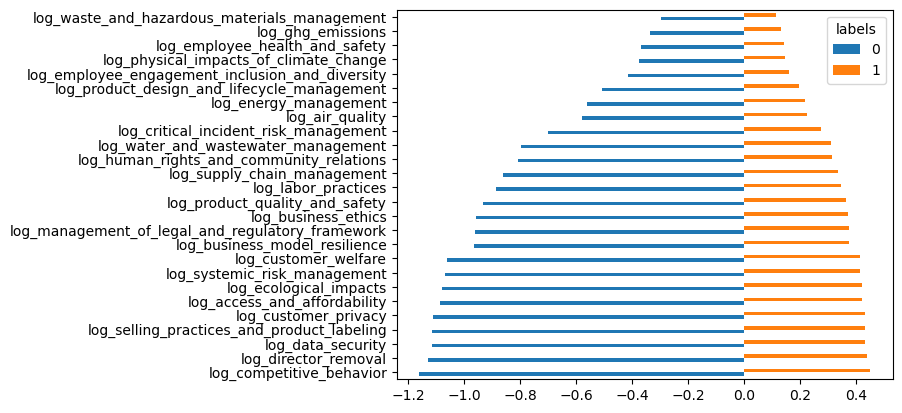

In [337]:
cluster_means.sort_values(0).plot(kind = 'barh')

As can be seen, there is a large difference between the PC1 average values, between class 0 and 1. Note that the mean values are both negative and positive, as the values are the **log** of the original proportion. Hence, a more negative mean is indicative of that topic accounting for less of the report.

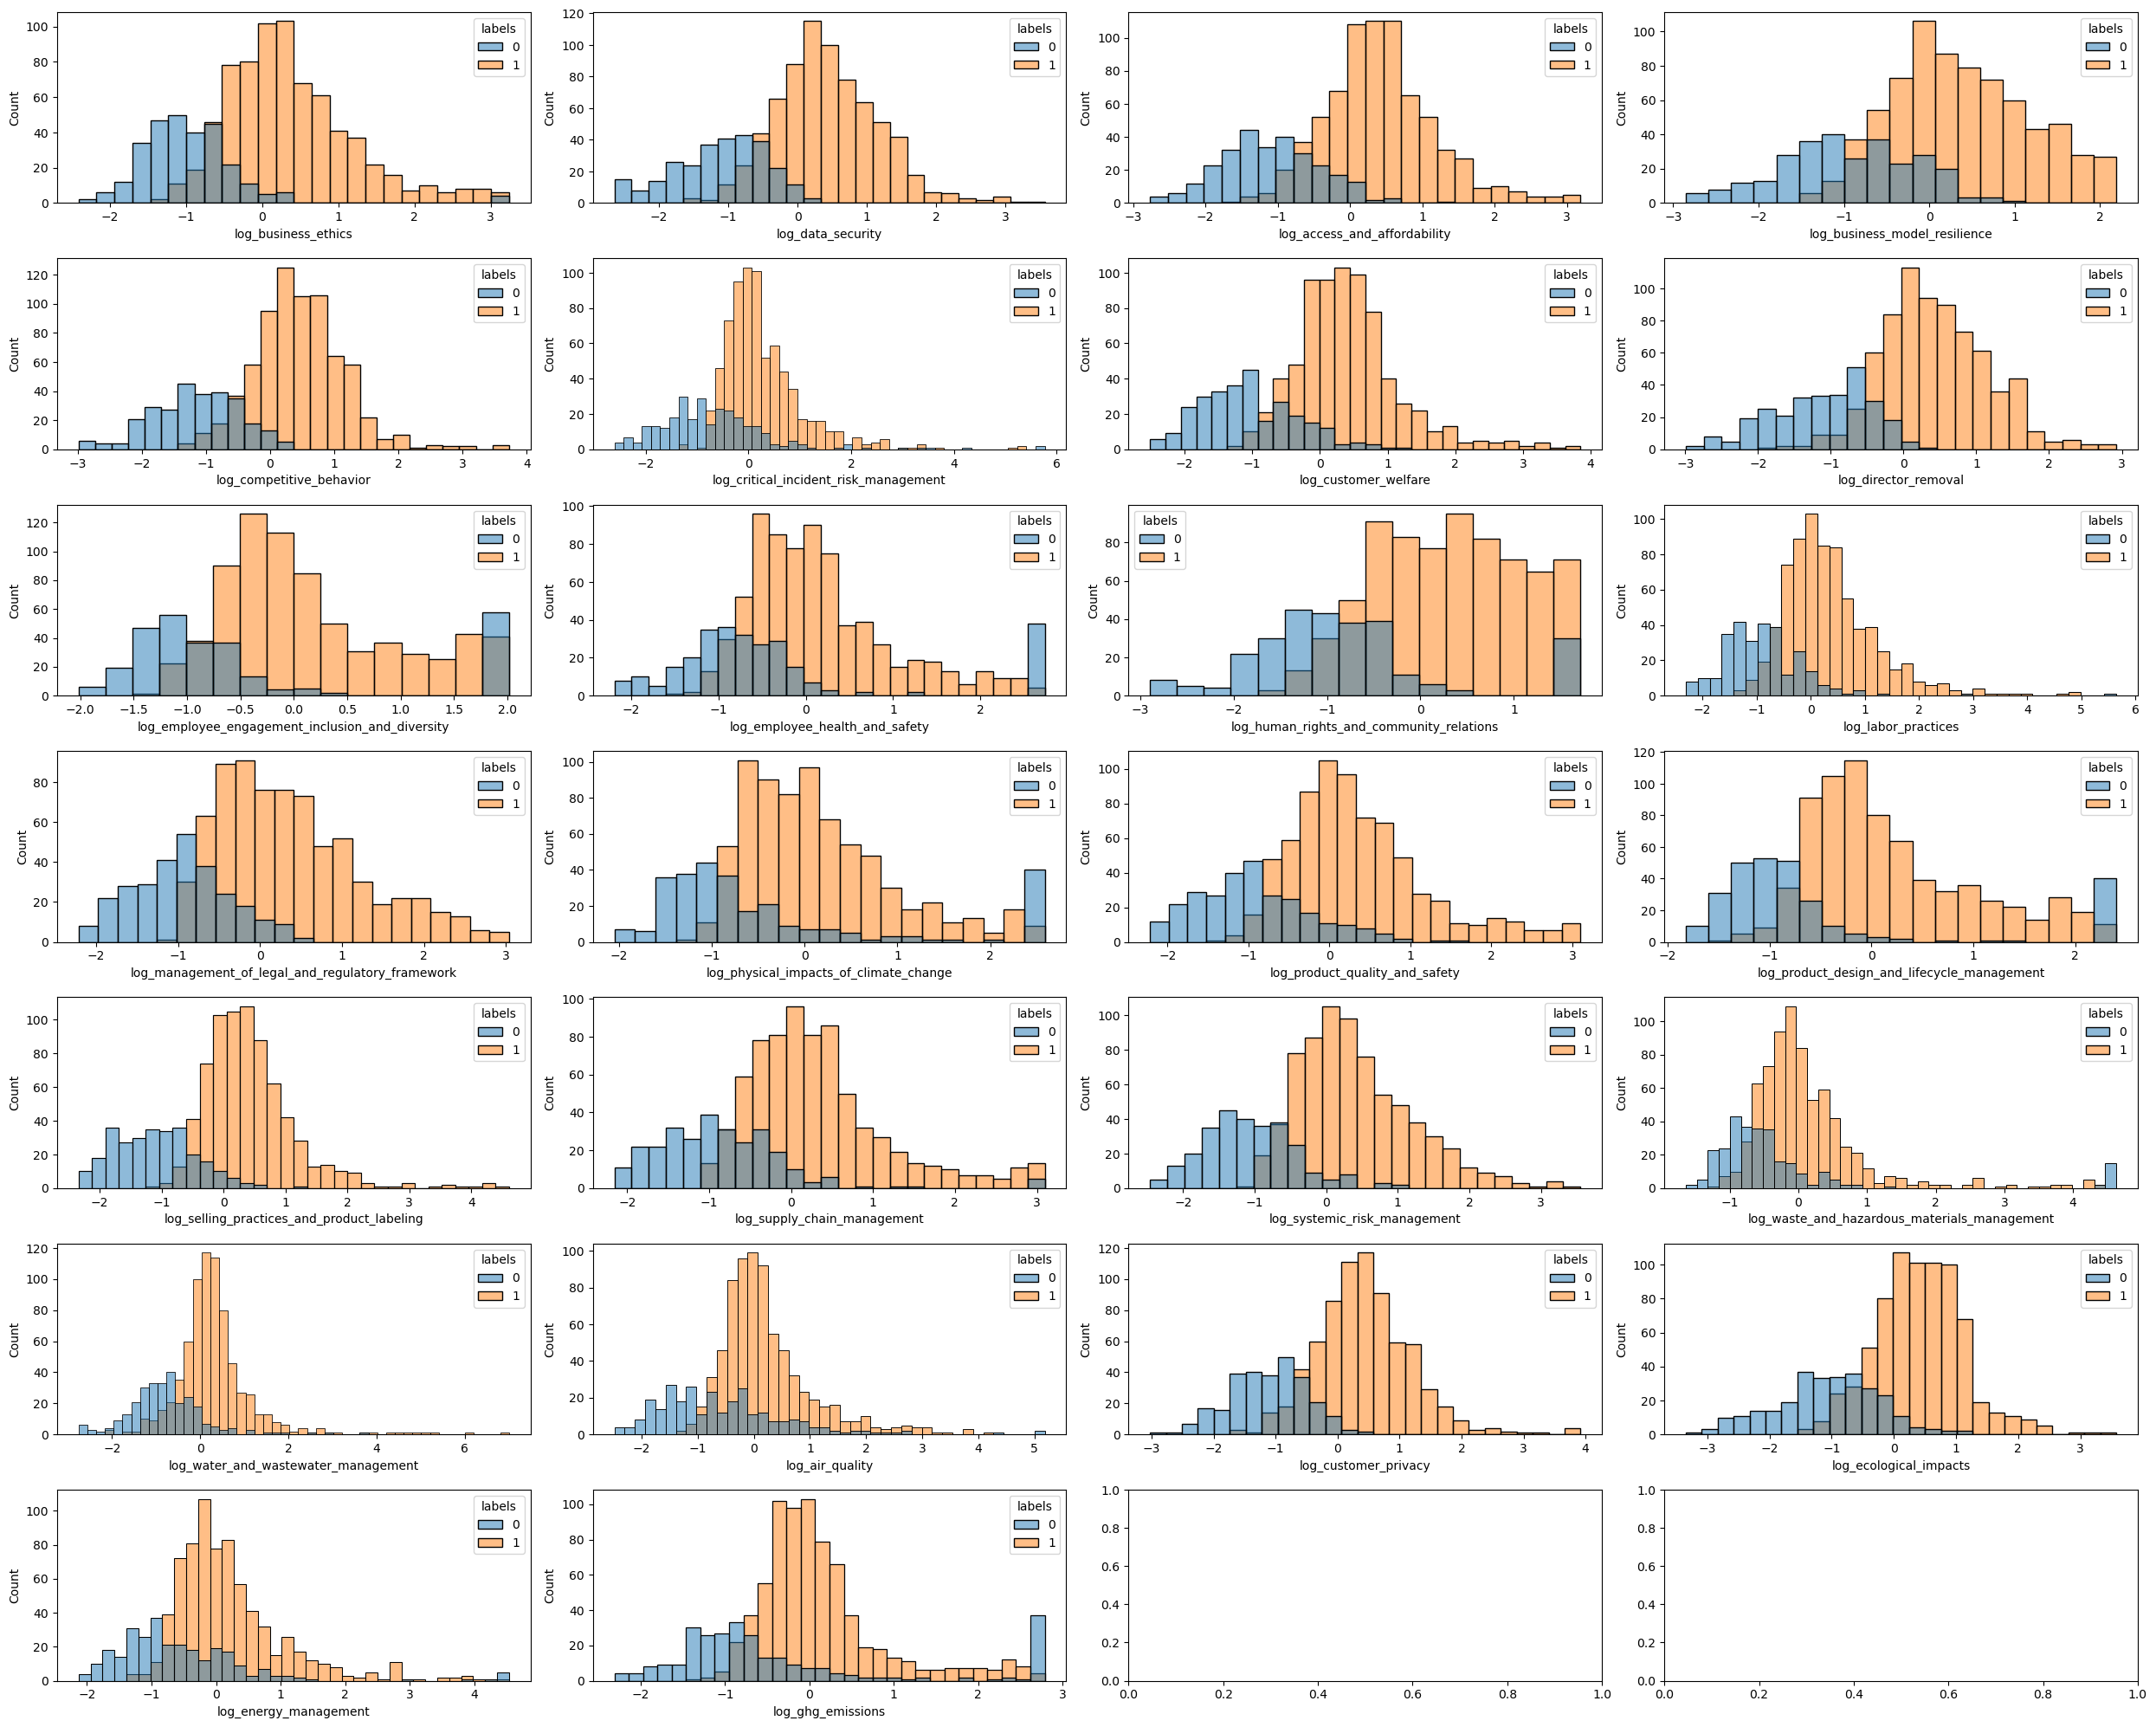

In [338]:
fig, axes = plt.subplots(7, 4, figsize=(25, 20))
i = 0

for ax, column in zip(axes.ravel(), clean_X.drop(columns='labels').columns):
    sns.histplot(data=clean_X, x=column, hue = 'labels', ax=ax)
    i += 1
    
plt.tight_layout()
plt.show()

The above findings suggest that the companies can be split into two main groups based on their ESG reports:

1. One cluster of companies appears to be much more focused on governance - competitor behaviour, director removal, data security (Group 0)
2. The other cluster appears to be more focused on environmental topics - waste and hazardous materials management, ghg emissions etc (Group 1)

This is a useful finding for if these features are to be used in a supervised learning project in the future. 

*NOTE that there was insufficient data to make this a supervised learning project, so this notebook is supplementary for any potential research at a later date.*